In [2]:
%pprint

import os
import json
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import xgboost as xgb
from xgboost import XGBClassifier

import sklearn
from sklearn import preprocessing
from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

from itertools import cycle
import warnings
from math import floor
from math import ceil

Pretty printing has been turned OFF


# Physical constants and histogram settings

In [3]:
# Luminosity 2012 and 2011
lumi12 = 11580.
lumi11 = 2330.

# MC cross section 
xsecZZ412 = 0.077
xsecZZ2mu2e12 = 0.18
xsecZZ411 = 0.067
xsecZZ2mu2e11 = 0.15

xsecTTBar12 = 200.
xsecTTBar11 = 177.31

xsecDY5012 = 2955.
xsecDY1012 = 10.742
xsecDY5011 = 2475.
xsecDY1011 = 9507.
  
# Scale factor 
sfZZ = 1.386
sfTTBar11 = 0.11
sfDY = 1.12

# For Higgs case, we use scaled cross section
scalexsecHZZ12 = 0.0065
scalexsecHZZ11 = 0.0057

# No. of event
nevtZZ4mu12 = 1499064
nevtZZ4e12 = 1499093
nevtZZ2mu2e12 = 1497445
nevtHZZ12 = 299973
nevtTTBar12 = 6423106
nevtDY5012 = 29426492
nevtDY1012 = 6462290
  
nevtZZ4mu11 = 1447136
nevtZZ4e11 = 1493308
nevtZZ2mu2e11 = 1479879
nevtHZZ11 = 299683
nevtTTBar11 = 9771205
nevtDY5011 = 36408225
nevtDY1011 = 39909640

# Scaling
scale_massHZZ11 = (lumi11 * scalexsecHZZ11) / nevtHZZ11
scale_massHZZ12 = (lumi12 * scalexsecHZZ12) / nevtHZZ12
scale_massZZ11_4mu = ((lumi11 * xsecZZ411 * sfZZ) / nevtZZ4mu11)
scale_massZZ12_4mu = ((lumi12 * xsecZZ412 * sfZZ) / nevtZZ4mu12)
scale_massZZ11_4e = ((lumi11 * xsecZZ411 * sfZZ) / nevtZZ4e11)
scale_massZZ12_4e = ((lumi12 * xsecZZ412 * sfZZ) / nevtZZ4e12)
scale_massZZ11_2mu2e = ((lumi11 * xsecZZ2mu2e11 * sfZZ) / nevtZZ2mu2e11)
scale_massZZ12_2mu2e = ((lumi12 * xsecZZ2mu2e12 * sfZZ) / nevtZZ2mu2e12)
scale_massTTbar11 = (lumi11 * xsecTTBar11 * sfTTBar11) / nevtTTBar11
scale_massTTbar12 = (lumi12 * xsecTTBar12) / nevtTTBar12
scale_massDY5011 = (lumi11 * xsecDY5011 * sfDY) / nevtDY5011
scale_massDY5012 = (lumi12 * xsecDY5012 * sfDY) / nevtDY5012
scale_massDY1011 = (lumi11 * xsecDY1011 * sfDY) / nevtDY1011
scale_massDY10HT20012 = (lumi12 * xsecDY1012 * sfDY) / nevtDY1012
scale_massDY10HT40012 = (lumi12 * xsecDY1012 * sfDY) / nevtDY1012

# Histogram
nbins = 37
xmin = 70
xmax = 181

# State
random_state = 42

# ML
test_size = 0.3
folds = 3
param_comb = 5

# Datasets path

In [4]:
base_path = "/mnt/rootfiles"
fpaths = sorted([os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))])
fnames = sorted([f for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))])

fpath_ZZ4mu12 = os.path.join(base_path, "MonteCarlo2012_Summer12_DR53X_ZZTo4mu_8TeV-powheg-pythia6_AODSIM_PU_RD1_START53_V7N-v1.root")
fpath_ZZ4e12 = os.path.join(base_path, "MonteCarlo2012_Summer12_DR53X_ZZTo4e_8TeV-powheg-pythia6_AODSIM_PU_RD1_START53_V7N-v2.root")
fpath_ZZ2mu2e12 = os.path.join(base_path, "MonteCarlo2012_Summer12_DR53X_ZZTo2e2mu_8TeV-powheg-pythia6_AODSIM_PU_RD1_START53_V7N-v2.root")
fpath_ZZ4mu11 = os.path.join(base_path, "MonteCarlo2011_Summer11LegDR_ZZTo4mu_mll4_7TeV-powheg-pythia6_AODSIM_PU_S13_START53_LV6-v1.root")
fpath_ZZ4e11 = os.path.join(base_path, "MonteCarlo2011_Summer11LegDR_ZZTo4e_mll4_7TeV-powheg-pythia6_AODSIM_PU_S13_START53_LV6-v1.root")
fpath_ZZ2mu2e11 = os.path.join(base_path, "MonteCarlo2011_Summer11LegDR_ZZTo2e2mu_mll4_7TeV-powheg-pythia6_AODSIM_PU_S13_START53_LV6-v1.root")
fpath_HZZ12 = os.path.join(base_path, "MonteCarlo2012_Summer12_DR53X_SMHiggsToZZTo4L_M-125_8TeV-powheg15-JHUgenV3-pythia6_AODSIM_PU_S10_START53_V19-v1.root")
fpath_HZZ11 = os.path.join(base_path, "MonteCarlo2011_Summer11LegDR_SMHiggsToZZTo4L_M-125_7TeV-powheg15-JHUgenV3-pythia6_AODSIM_PU_S13_START53_LV6-v1.root")
fpath_TTBar12 = os.path.join(base_path, "MonteCarlo2012_Summer12_DR53X_TTbar_8TeV-Madspin_aMCatNLO-herwig_AODSIM_PU_S10_START53_V19-v2.root")
fpath_TTBar11 = os.path.join(base_path, "MonteCarlo2011_Summer11LegDR_TTTo2L2Nu2B_7TeV-powheg-pythia6_AODSIM_PU_S13_START53_LV6-v1.root")
fpath_DY5012 = os.path.join(base_path, "MonteCarlo2012_Summer12_DR53X_DYJetsToLL_M-50_TuneZ2Star_8TeV-madgraph-tarball-tauola-tauPolarOff_AODSIM_PU_S10_START53_V19-v1.root")
fpath_DY5011 = os.path.join(base_path, "MonteCarlo2011_Summer11LegDR_DYJetsToLL_M-50_7TeV-madgraph-pythia6-tauola_AODSIM_PU_S13_START53_LV6-v1.root")
fpath_DY10_HT200to400_12 = os.path.join(base_path, "MonteCarlo2012_Summer12_DR53X_DYJetsToLL_M-10to50_HT-200to400_TuneZ2star_8TeV-madgraph-tauola_AODSIM_PU_S10_START53_V19-v1.root")
fpath_DY10_HT400toInf_12 = os.path.join(base_path, "MonteCarlo2012_Summer12_DR53X_DYJetsToLL_M-10to50_HT-400toInf_TuneZ2star_8TeV-madgraph-tauola_AODSIM_PU_S10_START53_V19-v1.root")
fpath_DY1011 = os.path.join(base_path, "MonteCarlo2011_Summer11LegDR_DYJetsToLL_M-10To50_TuneZ2_7TeV-pythia6_AODSIM_PU_S13_START53_LV6-v1.root")
fpath_DoubleMu12B = os.path.join(base_path, "Run2012B_DoubleMuParked_AOD_22Jan2013-v1.root")
fpath_DoubleMu12C = os.path.join(base_path, "Run2012C_DoubleMuParked_AOD_22Jan2013-v1.root")
fpath_DoubleMu11A = os.path.join(base_path, "Run2011A_DoubleMu_AOD_12Oct2013-v1.root")
fpath_DoubleElectron12B = os.path.join(base_path, "Run2012B_DoubleElectron_AOD_22Jan2013-v1.root")
fpath_DoubleElectron12C = os.path.join(base_path, "Run2012C_DoubleElectron_AOD_22Jan2013-v1.root")
fpath_DoubleElectron11A = os.path.join(base_path, "Run2011A_DoubleElectron_AOD_12Oct2013-v1.root")

# Converting Monte Carlo ROOTFiles to Pandas DataFrame

In [5]:
def root_to_dataframe(fpath, tree, event=None, label=None):
    inFile = uproot.open(fpath)
    data = inFile["demo"][tree].allvalues()
    data = {leaf.name.decode("utf-8"): leaf.array() for leaf in data}
    data = pd.DataFrame(data)
    if event:
        data["Event"] = pd.Series(np.repeat(event, data.shape[0]), index=data.index)
    if label:
        data["Label"] = pd.Series(np.repeat(label, data.shape[0]), index=data.index)
    inFile.close()
    return data

# (2012) ZZ -> {4mu, 4e, 2mu2e}
ZZto4mu12 = root_to_dataframe(fpath=fpath_ZZ4mu12, tree="tree4mu", event="ZZ4mu-12", label="b")
ZZto4e12 = root_to_dataframe(fpath=fpath_ZZ4e12, tree="tree4e", event="ZZ4e-12", label="b")
ZZto2mu2e12 = root_to_dataframe(fpath=fpath_ZZ2mu2e12, tree="tree2mu2e", event="ZZ2mu2e-12", label="b")

# (2011) ZZ -> {4mu, 4e, 2mu2e}
ZZto4mu11 = root_to_dataframe(fpath=fpath_ZZ4mu11, tree="tree4mu", event="ZZ4mu-11", label="b")
ZZto4e11 = root_to_dataframe(fpath=fpath_ZZ4e11, tree="tree4e", event="ZZ4e-11", label="b")
ZZto2mu2e11 = root_to_dataframe(fpath=fpath_ZZ2mu2e11, tree="tree2mu2e", event="ZZ2mu2e-11", label="b")

# (2012) H -> ZZ -> {4mu, 4e, 2mu2e}
HZZto4mu12 = root_to_dataframe(fpath=fpath_HZZ12, tree="tree4mu", event="HZZ4mu-12", label="s")
HZZto4e12 = root_to_dataframe(fpath=fpath_HZZ12, tree="tree4e", event="HZZ4e-12", label="s")
HZZto2mu2e12 = root_to_dataframe(fpath=fpath_HZZ12, tree="tree2mu2e", event="HZZ2mu2e-12", label="s")

# (2011) H -> ZZ -> {4mu, 4e, 2mu2e}
HZZto4mu11 = root_to_dataframe(fpath=fpath_HZZ11, tree="tree4mu", event="HZZ4mu-11", label="s")
HZZto4e11 = root_to_dataframe(fpath=fpath_HZZ11, tree="tree4e", event="HZZ4e-11", label="s")
HZZto2mu2e11 = root_to_dataframe(fpath=fpath_HZZ11, tree="tree2mu2e", event="HZZ2mu2e-11", label="s")

# (2012) TTBar -> {4mu, 4e, 2mu2e}
TTBarto4mu12 = root_to_dataframe(fpath=fpath_TTBar12, tree="tree4mu", event="TTBar4mu-12", label="b")
TTBarto4e12 = root_to_dataframe(fpath=fpath_TTBar12, tree="tree4e", event="TTBar4e-12", label="b")
TTBarto2mu2e12 = root_to_dataframe(fpath=fpath_TTBar12, tree="tree2mu2e", event="TTBar2mu2e-12", label="b")

# (2011) TTBar -> {4mu, 4e, 2mu2e}
TTBarto4mu11 = root_to_dataframe(fpath=fpath_TTBar11, tree="tree4mu", event="TTBar4mu-11", label="b")
TTBarto4e11 = root_to_dataframe(fpath=fpath_TTBar11, tree="tree4e", event="TTBar4e-11", label="b")
TTBarto2mu2e11 = root_to_dataframe(fpath=fpath_TTBar11, tree="tree2mu2e", event="TTBar2mu2e-11", label="b")

# (2012) DY 50 -> {4mu, 4e, 2mu2e}
DY50to4mu12 = root_to_dataframe(fpath=fpath_DY5012, tree="tree4mu", event="DY504mu-12", label="b")
DY50to4e12 = root_to_dataframe(fpath=fpath_DY5012, tree="tree4e", event="DY504e-12", label="b")
DY50to2mu2e12 = root_to_dataframe(fpath=fpath_DY5012, tree="tree2mu2e", event="DY502mu2e-12", label="b")

# (2011) DY 50 -> {4mu, 4e, 2mu2e}
DY50to4mu11 = root_to_dataframe(fpath=fpath_DY5011, tree="tree4mu", event="DY504mu-11", label="b")
DY50to4e11 = root_to_dataframe(fpath=fpath_DY5011, tree="tree4e", event="DY504e-11", label="b")
DY50to2mu2e11 = root_to_dataframe(fpath=fpath_DY5011, tree="tree2mu2e", event="DY502mu2e-11", label="b")

# (2012) DY 10-50 -> {4mu, 4e, 2mu2e}
DY10_HT200to400_to4mu12 = root_to_dataframe(fpath=fpath_DY10_HT200to400_12, tree="tree4mu", event="DY10_HT200to400_4mu-12", label="b")
DY10_HT200to400_to4e12 = root_to_dataframe(fpath=fpath_DY10_HT200to400_12, tree="tree4e", event="DY10_HT200to400_4e-12", label="b")
DY10_HT200to400_to2mu2e12 = root_to_dataframe(fpath=fpath_DY10_HT200to400_12, tree="tree2mu2e", event="DY10_HT200to400_2mu2e-12", label="b")

DY10_HT400toInf_to4mu12 = root_to_dataframe(fpath=fpath_DY10_HT400toInf_12, tree="tree4mu", event="DY10_HT400toInf_4mu-12", label="b")
DY10_HT400toInf_to4e12 = root_to_dataframe(fpath=fpath_DY10_HT400toInf_12, tree="tree4e", event="DY10_HT400toInf_4e-12", label="b")
DY10_HT400toInf_to2mu2e12 = root_to_dataframe(fpath=fpath_DY10_HT400toInf_12, tree="tree2mu2e", event="DY10_HT400toInf_2mu2e-12", label="b")

# (2011) DY 10-50 -> {4mu, 4e, 2mu2e}
DY10to4mu11 = root_to_dataframe(fpath=fpath_DY1011, tree="tree4mu", event="DY104mu-11", label="b")
DY10to4e11 = root_to_dataframe(fpath=fpath_DY1011, tree="tree4e", event="DY104e-11", label="b")
DY10to2mu2e11 = root_to_dataframe(fpath=fpath_DY1011, tree="tree2mu2e", event="DY102mu2e-11", label="b")

# Combining datasets of 4mu into signal and background
mc_4mu_bkg = [ZZto4mu12,ZZto4mu11,TTBarto4mu12,TTBarto4mu11,DY50to4mu12,DY50to4mu11,DY10_HT200to400_to4mu12,DY10_HT400toInf_to4mu12,DY10to4mu11]
mc_4mu_sig = [HZZto4mu12,HZZto4mu11]

bkg_4mu = pd.concat(mc_4mu_bkg).reset_index(drop=True)
sig_4mu = pd.concat(mc_4mu_sig).reset_index(drop=True)
mc_4mu = pd.concat([bkg_4mu, sig_4mu]).reset_index(drop=True)
mc_4mu = mc_4mu.drop("nRun", 1).drop("nEvt", 1).drop("nLumi", 1)
mc_4mu = mc_4mu.rename({"mass4mu": "mass"}, axis=1)
mc_4mu = mc_4mu.sample(frac=1, random_state=random_state).reset_index(drop=True)

# Combining datasets of 4e into signal and background
mc_4e_bkg = [ZZto4e12,ZZto4e11,TTBarto4e12,TTBarto4e11,DY50to4e12,DY50to4e11,DY10_HT200to400_to4e12,DY10_HT400toInf_to4e12,DY10to4e11]
mc_4e_sig = [HZZto4e12,HZZto4e11]

bkg_4e = pd.concat(mc_4e_bkg).reset_index(drop=True)
sig_4e = pd.concat(mc_4e_sig).reset_index(drop=True)
mc_4e = pd.concat([bkg_4e, sig_4e]).reset_index(drop=True)
mc_4e = mc_4e.drop("nRun", 1).drop("nEvt", 1).drop("nLumi", 1)
mc_4e = mc_4e.rename({"mass4e": "mass"}, axis=1)
mc_4e = mc_4e.sample(frac=1, random_state=random_state).reset_index(drop=True)

# Combining datasets of 2mu2e into signal and background
mc_2mu2e_bkg = [ZZto2mu2e12,ZZto2mu2e11,TTBarto2mu2e12,TTBarto2mu2e11,DY50to2mu2e12,DY50to2mu2e11,DY10_HT200to400_to2mu2e12,DY10_HT400toInf_to2mu2e12,DY10to2mu2e11]
mc_2mu2e_sig = [HZZto2mu2e12,HZZto2mu2e11]

bkg_2mu2e = pd.concat(mc_2mu2e_bkg).reset_index(drop=True)
sig_2mu2e = pd.concat(mc_2mu2e_sig).reset_index(drop=True)
mc_2mu2e = pd.concat([bkg_2mu2e, sig_2mu2e]).reset_index(drop=True)
mc_2mu2e = mc_2mu2e.drop("nRun", 1).drop("nEvt", 1).drop("nLumi", 1)
mc_2mu2e = mc_2mu2e.rename({"mass2mu2e": "mass"}, axis=1)
mc_2mu2e = mc_2mu2e.sample(frac=1, random_state=random_state).reset_index(drop=True)

# Computing Monte Carlo Weights

In [6]:
# Events -> 4mu
massHZZ11_4mu = mc_4mu.mass.values[np.where(mc_4mu.Event.values == "HZZ4mu-11")]
massHZZ12_4mu = mc_4mu.mass.values[np.where(mc_4mu.Event.values == "HZZ4mu-12")]
massZZ11_4mu = mc_4mu.mass.values[np.where(mc_4mu.Event.values == "ZZ4mu-11")]
massZZ12_4mu = mc_4mu.mass.values[np.where(mc_4mu.Event.values == "ZZ4mu-12")]
massTTbar11_4mu = mc_4mu.mass.values[np.where(mc_4mu.Event.values == "TTBar4mu-11")]
massTTbar12_4mu = mc_4mu.mass.values[np.where(mc_4mu.Event.values == "TTBar4mu-12")]
massDY5011_4mu = mc_4mu.mass.values[np.where(mc_4mu.Event.values == "DY504mu-11")]
massDY5012_4mu = mc_4mu.mass.values[np.where(mc_4mu.Event.values == "DY504mu-12")]
massDY1011_4mu = mc_4mu.mass.values[np.where(mc_4mu.Event.values == "DY104mu-11")]
massDY1012_HT200to400_4mu = mc_4mu.mass.values[np.where(mc_4mu.Event.values == "DY10_HT200to400_4mu-12")]
massDY1012_HT400toInf_4mu = mc_4mu.mass.values[np.where(mc_4mu.Event.values == "DY10_HT400toInf_4mu-12")]

mass_HZZ_4mu = np.concatenate([massHZZ11_4mu, massHZZ12_4mu], axis=0)
mass_ZZ_4mu = np.concatenate([massZZ11_4mu, massZZ12_4mu], axis=0)
mass_TTBar_4mu = np.concatenate([massTTbar11_4mu, massTTbar12_4mu], axis=0)
mass_DY50_4mu = np.concatenate([massDY5011_4mu, massDY5012_4mu], axis=0)
mass_DY10_4mu = np.concatenate([massDY1011_4mu, massDY1012_HT200to400_4mu, massDY1012_HT400toInf_4mu], axis=0)

weights_HZZ11_4mu = scale_massHZZ11*np.ones(massHZZ11_4mu.size)
weights_HZZ12_4mu = scale_massHZZ12*np.ones(massHZZ12_4mu.size)
weights_ZZ11_4mu = scale_massZZ11_4mu*np.ones(massZZ11_4mu.size)
weights_ZZ12_4mu = scale_massZZ12_4mu*np.ones(massZZ12_4mu.size)
weights_TTbar11_4mu = scale_massTTbar11*np.ones(massTTbar11_4mu.size)
weights_TTbar12_4mu = scale_massTTbar12*np.ones(massTTbar12_4mu.size)
weights_DY5011_4mu = scale_massDY5011*np.ones(massDY5011_4mu.size)
weights_DY5012_4mu = scale_massDY5012*np.ones(massDY5012_4mu.size)
weights_DY1011_4mu = scale_massDY1011*np.ones(massDY1011_4mu.size)
weights_DY1012_HT200to400_4mu = scale_massDY10HT20012*np.ones(massDY1012_HT200to400_4mu.size)
weights_DY1012_HT400toInf_4mu = scale_massDY10HT40012*np.ones(massDY1012_HT400toInf_4mu.size)

weights_HZZ_4mu = np.concatenate([weights_HZZ11_4mu, weights_HZZ12_4mu], axis=0)
weights_ZZ_4mu = np.concatenate([weights_ZZ11_4mu, weights_ZZ12_4mu], axis=0)
weights_TTBar_4mu = np.concatenate([weights_TTbar11_4mu, weights_TTbar12_4mu], axis=0)
weights_DY50_4mu = np.concatenate([weights_DY5011_4mu, weights_DY5012_4mu], axis=0)
weights_DY10_4mu = np.concatenate([weights_DY1011_4mu, weights_DY1012_HT200to400_4mu, weights_DY1012_HT400toInf_4mu], axis=0)

mc_4mu["Weights"] = pd.Series(np.nan, index=mc_4mu.index)
mc_4mu.loc[np.where(mc_4mu.Event.values == "HZZ4mu-11")[0], "Weights"] = weights_HZZ11_4mu
mc_4mu.loc[np.where(mc_4mu.Event.values == "HZZ4mu-12")[0], "Weights"] = weights_HZZ12_4mu
mc_4mu.loc[np.where(mc_4mu.Event.values == "ZZ4mu-11")[0], "Weights"] = weights_ZZ11_4mu
mc_4mu.loc[np.where(mc_4mu.Event.values == "ZZ4mu-12")[0], "Weights"] = weights_ZZ12_4mu
mc_4mu.loc[np.where(mc_4mu.Event.values == "TTBar4mu-11")[0], "Weights"] = weights_TTbar11_4mu
mc_4mu.loc[np.where(mc_4mu.Event.values == "TTBar4mu-12")[0], "Weights"] = weights_TTbar12_4mu
mc_4mu.loc[np.where(mc_4mu.Event.values == "DY504mu-11")[0], "Weights"] = weights_DY5011_4mu
mc_4mu.loc[np.where(mc_4mu.Event.values == "DY504mu-12")[0], "Weights"] = weights_DY5012_4mu
mc_4mu.loc[np.where(mc_4mu.Event.values == "DY104mu-11")[0], "Weights"] = weights_DY1011_4mu
mc_4mu.loc[np.where(mc_4mu.Event.values == "DY10_HT200to400_4mu-12")[0], "Weights"] = weights_DY1012_HT200to400_4mu
mc_4mu.loc[np.where(mc_4mu.Event.values == "DY10_HT400toInf_4mu-12")[0], "Weights"] = weights_DY1012_HT400toInf_4mu

# Events -> 4e
massHZZ11_4e = mc_4e.mass.values[np.where(mc_4e.Event.values == "HZZ4e-11")]
massHZZ12_4e = mc_4e.mass.values[np.where(mc_4e.Event.values == "HZZ4e-12")]
massZZ11_4e = mc_4e.mass.values[np.where(mc_4e.Event.values == "ZZ4e-11")]
massZZ12_4e = mc_4e.mass.values[np.where(mc_4e.Event.values == "ZZ4e-12")]
massTTbar11_4e = mc_4e.mass.values[np.where(mc_4e.Event.values == "TTBar4e-11")]
massTTbar12_4e = mc_4e.mass.values[np.where(mc_4e.Event.values == "TTBar4e-12")]
massDY5011_4e = mc_4e.mass.values[np.where(mc_4e.Event.values == "DY504e-11")]
massDY5012_4e = mc_4e.mass.values[np.where(mc_4e.Event.values == "DY504e-12")]
massDY1011_4e = mc_4e.mass.values[np.where(mc_4e.Event.values == "DY104e-11")]
massDY1012_HT200to400_4e = mc_4e.mass.values[np.where(mc_4e.Event.values == "DY10_HT200to400_4e-12")]
massDY1012_HT400toInf_4e = mc_4e.mass.values[np.where(mc_4e.Event.values == "DY10_HT400toInf_4e-12")]

mass_HZZ_4e = np.concatenate([massHZZ11_4e, massHZZ12_4e], axis=0)
mass_ZZ_4e = np.concatenate([massZZ11_4e, massZZ12_4e], axis=0)
mass_TTBar_4e = np.concatenate([massTTbar11_4e, massTTbar12_4e], axis=0)
mass_DY50_4e = np.concatenate([massDY5011_4e, massDY5012_4e], axis=0)
mass_DY10_4e = np.concatenate([massDY1011_4e, massDY1012_HT200to400_4e, massDY1012_HT400toInf_4e], axis=0)

weights_HZZ11_4e = scale_massHZZ11*np.ones(massHZZ11_4e.size)
weights_HZZ12_4e = scale_massHZZ12*np.ones(massHZZ12_4e.size)
weights_ZZ11_4e = scale_massZZ11_4e*np.ones(massZZ11_4e.size)
weights_ZZ12_4e = scale_massZZ12_4e*np.ones(massZZ12_4e.size)
weights_TTbar11_4e = scale_massTTbar11*np.ones(massTTbar11_4e.size)
weights_TTbar12_4e = scale_massTTbar12*np.ones(massTTbar12_4e.size)
weights_DY5011_4e = scale_massDY5011*np.ones(massDY5011_4e.size)
weights_DY5012_4e = scale_massDY5012*np.ones(massDY5012_4e.size)
weights_DY1011_4e = scale_massDY1011*np.ones(massDY1011_4e.size)
weights_DY1012_HT200to400_4e = scale_massDY10HT20012*np.ones(massDY1012_HT200to400_4e.size)
weights_DY1012_HT400toInf_4e = scale_massDY10HT40012*np.ones(massDY1012_HT400toInf_4e.size)

weights_HZZ_4e = np.concatenate([weights_HZZ11_4e, weights_HZZ12_4e], axis=0)
weights_ZZ_4e = np.concatenate([weights_ZZ11_4e, weights_ZZ12_4e], axis=0)
weights_TTBar_4e = np.concatenate([weights_TTbar11_4e, weights_TTbar12_4e], axis=0)
weights_DY50_4e = np.concatenate([weights_DY5011_4e, weights_DY5012_4e], axis=0)
weights_DY10_4e = np.concatenate([weights_DY1011_4e, weights_DY1012_HT200to400_4e, weights_DY1012_HT400toInf_4e], axis=0)

mc_4e["Weights"] = pd.Series(np.nan, index=mc_4e.index)
mc_4e.loc[np.where(mc_4e.Event.values == "HZZ4e-11")[0], "Weights"] = weights_HZZ11_4e
mc_4e.loc[np.where(mc_4e.Event.values == "HZZ4e-12")[0], "Weights"] = weights_HZZ12_4e
mc_4e.loc[np.where(mc_4e.Event.values == "ZZ4e-11")[0], "Weights"] = weights_ZZ11_4e
mc_4e.loc[np.where(mc_4e.Event.values == "ZZ4e-12")[0], "Weights"] = weights_ZZ12_4e
mc_4e.loc[np.where(mc_4e.Event.values == "TTBar4e-11")[0], "Weights"] = weights_TTbar11_4e
mc_4e.loc[np.where(mc_4e.Event.values == "TTBar4e-12")[0], "Weights"] = weights_TTbar12_4e
mc_4e.loc[np.where(mc_4e.Event.values == "DY504e-11")[0], "Weights"] = weights_DY5011_4e
mc_4e.loc[np.where(mc_4e.Event.values == "DY504e-12")[0], "Weights"] = weights_DY5012_4e
mc_4e.loc[np.where(mc_4e.Event.values == "DY104e-11")[0], "Weights"] = weights_DY1011_4e
mc_4e.loc[np.where(mc_4e.Event.values == "DY10_HT200to400_4e-12")[0], "Weights"] = weights_DY1012_HT200to400_4e
mc_4e.loc[np.where(mc_4e.Event.values == "DY10_HT400toInf_4e-12")[0], "Weights"] = weights_DY1012_HT400toInf_4e

# Events -> 2mu2e
massHZZ11_2mu2e = mc_2mu2e.mass.values[np.where(mc_2mu2e.Event.values == "HZZ2mu2e-11")]
massHZZ12_2mu2e = mc_2mu2e.mass.values[np.where(mc_2mu2e.Event.values == "HZZ2mu2e-12")]
massZZ11_2mu2e = mc_2mu2e.mass.values[np.where(mc_2mu2e.Event.values == "ZZ2mu2e-11")]
massZZ12_2mu2e = mc_2mu2e.mass.values[np.where(mc_2mu2e.Event.values == "ZZ2mu2e-12")]
massTTbar11_2mu2e = mc_2mu2e.mass.values[np.where(mc_2mu2e.Event.values == "TTBar2mu2e-11")]
massTTbar12_2mu2e = mc_2mu2e.mass.values[np.where(mc_2mu2e.Event.values == "TTBar2mu2e-12")]
massDY5011_2mu2e = mc_2mu2e.mass.values[np.where(mc_2mu2e.Event.values == "DY502mu2e-11")]
massDY5012_2mu2e = mc_2mu2e.mass.values[np.where(mc_2mu2e.Event.values == "DY502mu2e-12")]
massDY1011_2mu2e = mc_2mu2e.mass.values[np.where(mc_2mu2e.Event.values == "DY102mu2e-11")]
massDY1012_HT200to400_2mu2e = mc_2mu2e.mass.values[np.where(mc_2mu2e.Event.values == "DY10_HT200to400_2mu2e-12")]
massDY1012_HT400toInf_2mu2e = mc_2mu2e.mass.values[np.where(mc_2mu2e.Event.values == "DY10_HT400toInf_2mu2e-12")]

mass_HZZ_2mu2e = np.concatenate([massHZZ11_2mu2e, massHZZ12_2mu2e], axis=0)
mass_ZZ_2mu2e = np.concatenate([massZZ11_2mu2e, massZZ12_2mu2e], axis=0)
mass_TTBar_2mu2e = np.concatenate([massTTbar11_2mu2e, massTTbar12_2mu2e], axis=0)
mass_DY50_2mu2e = np.concatenate([massDY5011_2mu2e, massDY5012_2mu2e], axis=0)
mass_DY10_2mu2e = np.concatenate([massDY1011_2mu2e, massDY1012_HT200to400_2mu2e, massDY1012_HT400toInf_2mu2e], axis=0)

weights_HZZ11_2mu2e = scale_massHZZ11*np.ones(massHZZ11_2mu2e.size)
weights_HZZ12_2mu2e = scale_massHZZ12*np.ones(massHZZ12_2mu2e.size)
weights_ZZ11_2mu2e = scale_massZZ11_2mu2e*np.ones(massZZ11_2mu2e.size)
weights_ZZ12_2mu2e = scale_massZZ12_2mu2e*np.ones(massZZ12_2mu2e.size)
weights_TTbar11_2mu2e = scale_massTTbar11*np.ones(massTTbar11_2mu2e.size)
weights_TTbar12_2mu2e = scale_massTTbar12*np.ones(massTTbar12_2mu2e.size)
weights_DY5011_2mu2e = scale_massDY5011*np.ones(massDY5011_2mu2e.size)
weights_DY5012_2mu2e = scale_massDY5012*np.ones(massDY5012_2mu2e.size)
weights_DY1011_2mu2e = scale_massDY1011*np.ones(massDY1011_2mu2e.size)
weights_DY1012_HT200to400_2mu2e = scale_massDY10HT20012*np.ones(massDY1012_HT200to400_2mu2e.size)
weights_DY1012_HT400toInf_2mu2e = scale_massDY10HT40012*np.ones(massDY1012_HT400toInf_2mu2e.size)

weights_HZZ_2mu2e = np.concatenate([weights_HZZ11_2mu2e, weights_HZZ12_2mu2e], axis=0)
weights_ZZ_2mu2e = np.concatenate([weights_ZZ11_2mu2e, weights_ZZ12_2mu2e], axis=0)
weights_TTBar_2mu2e = np.concatenate([weights_TTbar11_2mu2e, weights_TTbar12_2mu2e], axis=0)
weights_DY50_2mu2e = np.concatenate([weights_DY5011_2mu2e, weights_DY5012_2mu2e], axis=0)
weights_DY10_2mu2e = np.concatenate([weights_DY1011_2mu2e, weights_DY1012_HT200to400_2mu2e, weights_DY1012_HT400toInf_2mu2e], axis=0)

mc_2mu2e["Weights"] = pd.Series(np.nan, index=mc_2mu2e.index)
mc_2mu2e.loc[np.where(mc_2mu2e.Event.values == "HZZ2mu2e-11")[0], "Weights"] = weights_HZZ11_2mu2e
mc_2mu2e.loc[np.where(mc_2mu2e.Event.values == "HZZ2mu2e-12")[0], "Weights"] = weights_HZZ12_2mu2e
mc_2mu2e.loc[np.where(mc_2mu2e.Event.values == "ZZ2mu2e-11")[0], "Weights"] = weights_ZZ11_2mu2e
mc_2mu2e.loc[np.where(mc_2mu2e.Event.values == "ZZ2mu2e-12")[0], "Weights"] = weights_ZZ12_2mu2e
mc_2mu2e.loc[np.where(mc_2mu2e.Event.values == "TTBar2mu2e-11")[0], "Weights"] = weights_TTbar11_2mu2e
mc_2mu2e.loc[np.where(mc_2mu2e.Event.values == "TTBar2mu2e-12")[0], "Weights"] = weights_TTbar12_2mu2e
mc_2mu2e.loc[np.where(mc_2mu2e.Event.values == "DY502mu2e-11")[0], "Weights"] = weights_DY5011_2mu2e
mc_2mu2e.loc[np.where(mc_2mu2e.Event.values == "DY502mu2e-12")[0], "Weights"] = weights_DY5012_2mu2e
mc_2mu2e.loc[np.where(mc_2mu2e.Event.values == "DY102mu2e-11")[0], "Weights"] = weights_DY1011_2mu2e
mc_2mu2e.loc[np.where(mc_2mu2e.Event.values == "DY10_HT200to400_2mu2e-12")[0], "Weights"] = weights_DY1012_HT200to400_2mu2e
mc_2mu2e.loc[np.where(mc_2mu2e.Event.values == "DY10_HT400toInf_2mu2e-12")[0], "Weights"] = weights_DY1012_HT400toInf_2mu2e

# Converting Real Data ROOTFiles to Pandas DataFrame

In [7]:
# (2012) Event -> {4mu, 4e, 2mu2e}
DoubleMu_B_4mu12 = root_to_dataframe(fpath=fpath_DoubleMu12B, tree="tree4mu")
DoubleMu_B_2mu2e12 = root_to_dataframe(fpath=fpath_DoubleMu12B, tree="tree2mu2e")
DoubleE_B_4e12 = root_to_dataframe(fpath=fpath_DoubleElectron12B, tree="tree4e")

DoubleMu_C_4mu12 = root_to_dataframe(fpath=fpath_DoubleMu12C, tree="tree4mu")
DoubleMu_C_2mu2e12 = root_to_dataframe(fpath=fpath_DoubleMu12C, tree="tree2mu2e")
DoubleE_C_4e12 = root_to_dataframe(fpath=fpath_DoubleElectron12C, tree="tree4e")

# (2011) Event -> {4mu, 4e, 2mu2e}
DoubleMu4mu11 = root_to_dataframe(fpath=fpath_DoubleMu11A, tree="tree4mu")
DoubleMu2mu2e11 = root_to_dataframe(fpath=fpath_DoubleMu11A, tree="tree2mu2e")
DoubleE4e11 = root_to_dataframe(fpath=fpath_DoubleElectron11A, tree="tree4e")

# Listing data
data_4mu = [DoubleMu_B_4mu12, DoubleMu_C_4mu12, DoubleMu4mu11]
data_2mu2e = [DoubleMu_B_2mu2e12, DoubleMu_C_2mu2e12, DoubleMu2mu2e11]
data_4e = [DoubleE_B_4e12, DoubleE_C_4e12, DoubleE4e11]

# Combining to Pandas DF
data_4mu = pd.concat(data_4mu).reset_index(drop=True)
data_4e = pd.concat(data_4e).reset_index(drop=True)
data_2mu2e = pd.concat(data_2mu2e).reset_index(drop=True)

data_4mu = data_4mu.rename({"mass4mu": "mass"}, axis=1)
data_2mu2e = data_2mu2e.rename({"mass2mu2e": "mass"}, axis=1)
data_4e = data_4e.rename({"mass4e": "mass"}, axis=1)

# Invariant Mass Plot

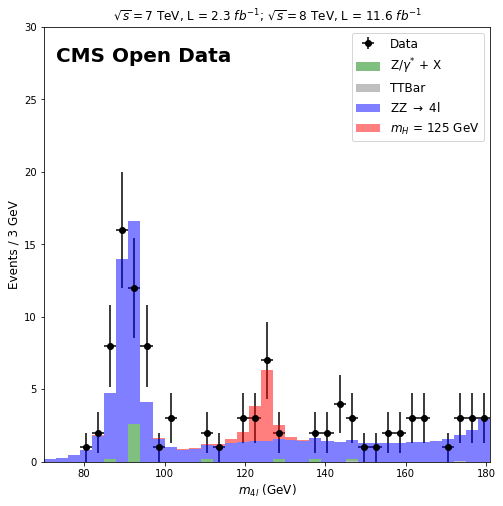

In [8]:
# Real data
data = pd.concat([data_4mu, data_4e, data_2mu2e]).reset_index(drop=True)

# Monte carlo simulation
massHZZ = np.concatenate([mass_HZZ_4mu, mass_HZZ_4e, mass_HZZ_2mu2e], axis=0)
massZZ = np.concatenate([mass_ZZ_4mu, mass_ZZ_4e, mass_ZZ_2mu2e], axis=0)
massTTBar = np.concatenate([mass_TTBar_4mu, mass_TTBar_4e, mass_TTBar_2mu2e], axis=0)
massDY50 = np.concatenate([mass_DY50_4mu, mass_DY50_4e, mass_DY50_2mu2e], axis=0)
massDY10 = np.concatenate([mass_DY10_4mu, mass_DY10_4e, mass_DY10_2mu2e], axis=0)
massDY = np.concatenate([massDY50, massDY10], axis=0)

# Monte carlo weights
weightsHZZ = np.concatenate([weights_HZZ_4mu, weights_HZZ_4e, weights_HZZ_2mu2e], axis=0)
weightsZZ = np.concatenate([weights_ZZ_4mu, weights_ZZ_4e, weights_ZZ_2mu2e], axis=0)
weightsTTBar = np.concatenate([weights_TTBar_4mu, weights_TTBar_4e, weights_TTBar_2mu2e], axis=0)
weightsDY50 = np.concatenate([weights_DY50_4mu, weights_DY50_4e, weights_DY50_2mu2e], axis=0)
weightsDY10 = np.concatenate([weights_DY10_4mu, weights_DY10_4e, weights_DY10_2mu2e], axis=0)
weightsDY = np.concatenate([weightsDY50, weightsDY10], axis=0)

# Computing frequency and bins for Data, and masking the scatter plot
n_data, bin_edges = np.histogram(data.mass.values, bins=nbins, range=(xmin,xmax))
data_mask = n_data > 0

# Computing frequency and bins for MC
n_HZZ, bin_edges = np.histogram(massHZZ, bins=nbins, range=(xmin,xmax), weights=weightsHZZ)
n_ZZ, bin_edges = np.histogram(massZZ, bins=nbins, range=(xmin,xmax), weights=weightsZZ)
n_TTbar, bin_edges = np.histogram(massTTBar, bins=nbins, range=(xmin,xmax), weights=weightsTTBar)
n_DY, bin_edges = np.histogram(massDY, bins=nbins, range=(xmin,xmax), weights=weightsDY)

HZZ_mask = n_HZZ > 0
ZZ_mask = n_ZZ > 0
TTBar_mask = n_TTbar > 0
DY_mask = n_DY > 0

# Computing bin width and x-axis centered values
width = 1.0*(bin_edges[1] - bin_edges[0])
center = (bin_edges[:-1] + bin_edges[1:])/2.

# Ploting using bar method
plt.figure(figsize = (8,8))
plt.errorbar(center[data_mask], n_data[data_mask], yerr=np.sqrt(n_data[data_mask]), xerr=(width/2)*np.ones(n_data[data_mask].size), marker="o", color="black", linestyle='None', label="Data", zorder=1)
plt.bar(center, n_DY, width=width, align='center', color="g", bottom=n_TTbar, linewidth=0, edgecolor='black', alpha=0.5, label='Z/$\gamma^{*}$ + X')
plt.bar(center, n_TTbar, width=width, align='center', color="grey", linewidth=0, edgecolor='black', alpha=0.5, label='TTBar')
plt.bar(center, n_ZZ, width=width, align='center', color="b", bottom=n_TTbar+n_DY, linewidth=0, edgecolor='black', alpha=0.5, label=r'ZZ $\rightarrow$ 4l')
plt.bar(center, n_HZZ, width=width, align='center', color="r", bottom=n_TTbar+n_DY+n_ZZ, linewidth=0, edgecolor='red', alpha=0.5, label='$m_{H}$ = 125 GeV', fill=True)
#plt.plot(center+width/2, n_HZZ, color="r", linewidth=1, label='$m_{H}$ = 125 GeV', drawstyle="steps")
plt.xlim((xmin,xmax))
plt.ylim((0, 30))
plt.xlabel('$m_{4l}$ (GeV)', fontsize = 12)
plt.ylabel(f'Events / {int(width)} GeV', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize = 12)
plt.savefig("mass4l_combined.png", dpi = 300)

## -----------------------------
## CMS Notation
## -----------------------------
## Obtenção dos limites do gráfico
x_begin, x_end = plt.xlim()
y_begin, y_end = plt.ylim()

## Ajuste fino da posição
## caso o texto fique muito alto/baixo
adj_x = 3
adj_y = -2

## Inserção do texto
plt.text(x_begin + adj_x, y_end + adj_y,\
         'CMS Open Data',\
         horizontalalignment='left',\
         verticalalignment='center',\
         fontsize=20, \
         fontweight='bold')

plt.show()

# Looking 4mu events ratio and splitting dataset into train and test

In [9]:
lbl = preprocessing.LabelEncoder()
mc_4mu["Label"] = lbl.fit_transform(mc_4mu.Label.astype(str))
train_4mu, test_4mu = train_test_split(mc_4mu, test_size=test_size, random_state=random_state)
train_4mu, test_4mu = train_4mu.reset_index(drop=True), test_4mu.reset_index(drop=True)

n_signal_4mu = len(np.where(mc_4mu.Label == 1)[0])
n_background_4mu = len(np.where(mc_4mu.Label == 0)[0])
n_events_4mu = n_signal_4mu + n_background_4mu

print(f"Number of signal events: {n_signal_4mu}")
print(f"Number of background events: {n_background_4mu}")
print(f"Fraction of signal: {n_signal_4mu/n_events_4mu}")

Number of signal events: 23841
Number of background events: 198772
Fraction of signal: 0.10709617138262366


# Selecting Features

In [10]:
# Selecting variables from df columns
variables_4mu = mc_4mu.columns.values

# Removing unwanted varibales
remove = np.array([
    'pz4mu', 'E4mu', 'eta_mu3', 
    'cas_mu2', 'px_mu1', 'py_mu3', 
    "cas_mu1", "cas_mu3", "cas_mu4", 
    "pz_mu4", "eta_mu4", "pz_mu3", 
    "phi_4mu", "phi_mu1", "pz_mu1", 
    "px_mu3", "phi_mu3", "eta_mu2", 
    "phi_mu3", "py_mu4", "px_mu4", 
    "phi_mu2", "py_mu2"
])
features_4mu = np.delete(variables_4mu, np.where(variables_4mu == "Event"), axis=0)
features_4mu = np.delete(features_4mu, np.where(features_4mu == "Label"), axis=0)
features_4mu = np.delete(features_4mu, np.where(features_4mu == "Weights"), axis=0)
features_4mu = np.setdiff1d(features_4mu, remove)

# Selecting X and y
X_train_4mu, y_train_4mu = train_4mu, train_4mu.Label.values
X_test_4mu, y_test_4mu = test_4mu[features_4mu], test_4mu.Label.values

weights_train_4mu, evt_train_4mu = train_4mu.Weights.values, train_4mu.Event.values
weights_test_4mu, evt_test_4mu = test_4mu.Weights.values, test_4mu.Event.values

condition_zz_hzz = np.where(~((X_train_4mu.Event.values != "ZZ4mu-12") &
                    (X_train_4mu.Event.values != "ZZ4e-12") &
                    (X_train_4mu.Event.values != "ZZ2mu2e-12") &
                    (X_train_4mu.Event.values != "ZZ4mu-11") &
                    (X_train_4mu.Event.values != "ZZ4e-11") &
                    (X_train_4mu.Event.values != "ZZ2mu2e-11") &
                    (X_train_4mu.Event.values != "HZZ4mu-12") &
                    (X_train_4mu.Event.values != "HZZ4e-12") &
                    (X_train_4mu.Event.values != "HZZ2mu2e-12") &
                    (X_train_4mu.Event.values != "HZZ4mu-11") &
                    (X_train_4mu.Event.values != "HZZ4e-11") &
                    (X_train_4mu.Event.values != "HZZ2mu2e-11")))

weights_train_4mu = weights_train_4mu[condition_zz_hzz[0]]
y_train_4mu = y_train_4mu[condition_zz_hzz[0]]
X_train_4mu = X_train_4mu.iloc[condition_zz_hzz[0]].reset_index(drop=True)
X_train_4mu = X_train_4mu[features_4mu]

print(features_4mu)

['E_mu1' 'E_mu2' 'E_mu3' 'E_mu4' 'eta_4mu' 'eta_mu1' 'mZa' 'mZb' 'mass'
 'phi_mu4' 'pt_4mu' 'pt_mu1' 'pt_mu2' 'pt_mu3' 'pt_mu4' 'px4mu' 'px_mu2'
 'py4mu' 'py_mu1' 'pz_mu2']


# Simulation vs Data on selected features (4mu)

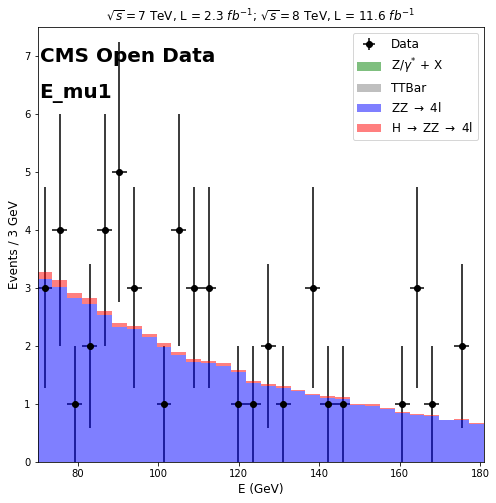

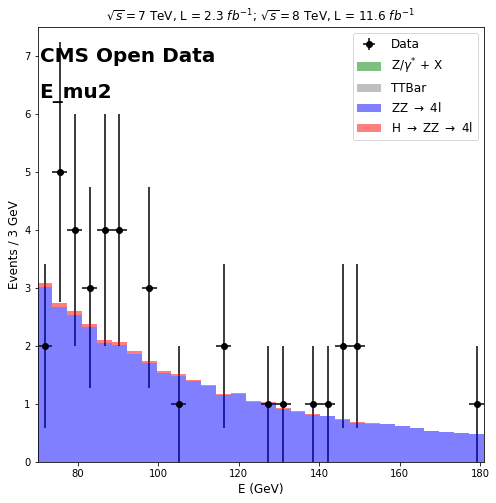

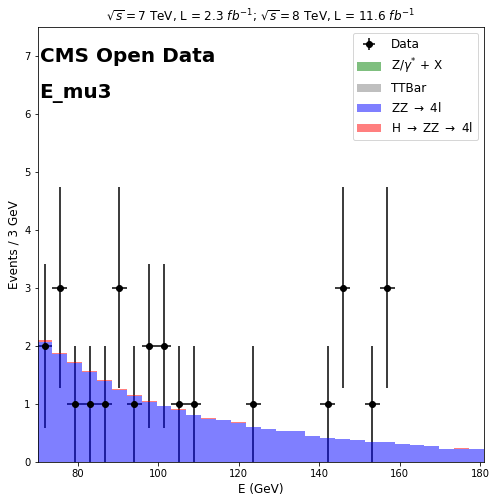

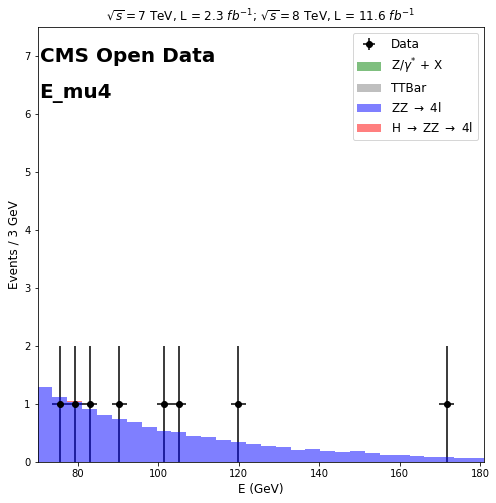

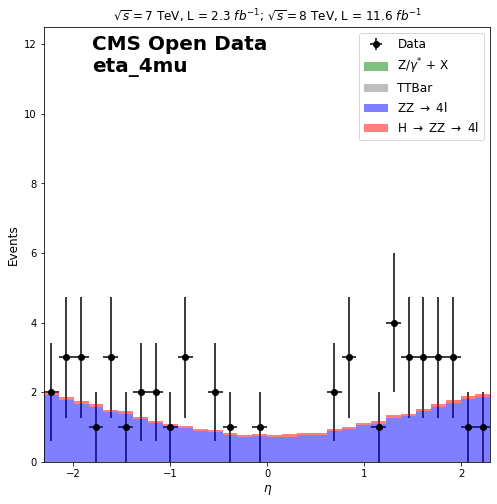

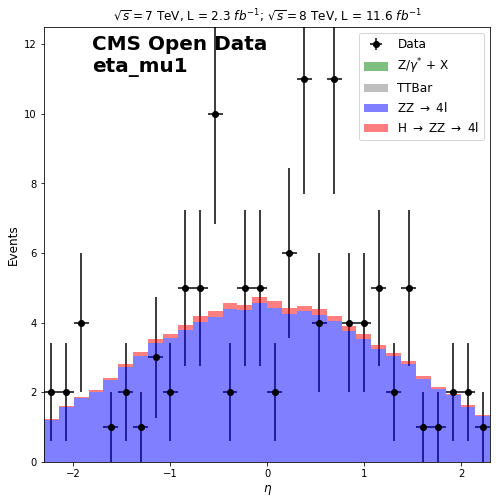

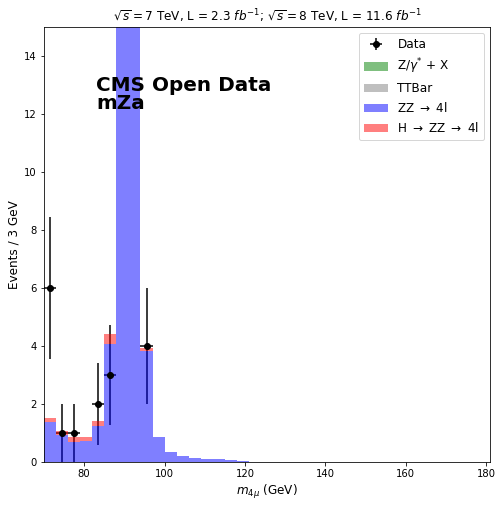

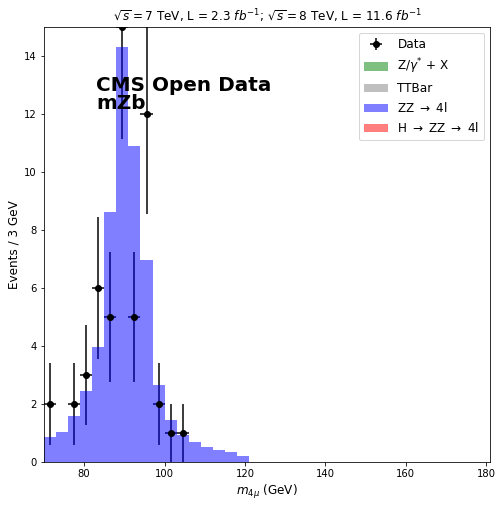

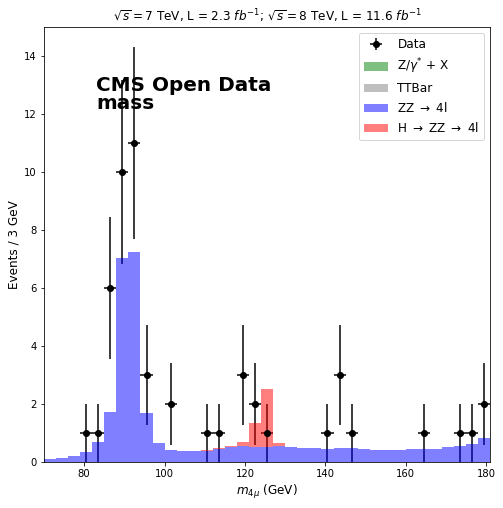

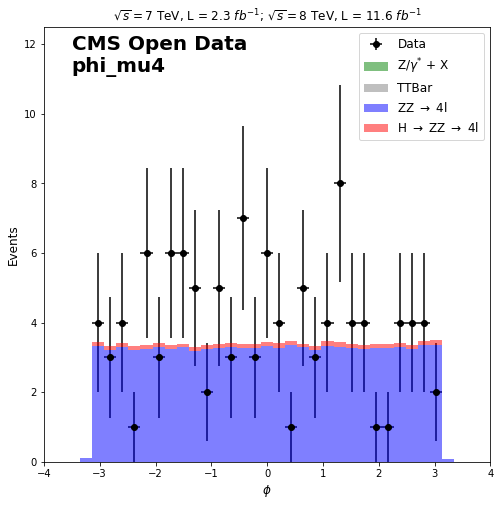

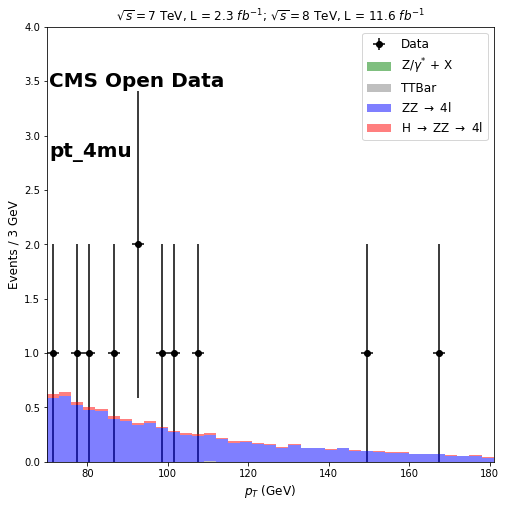

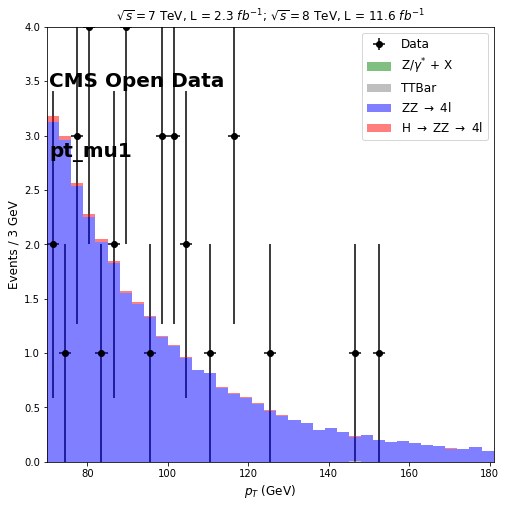

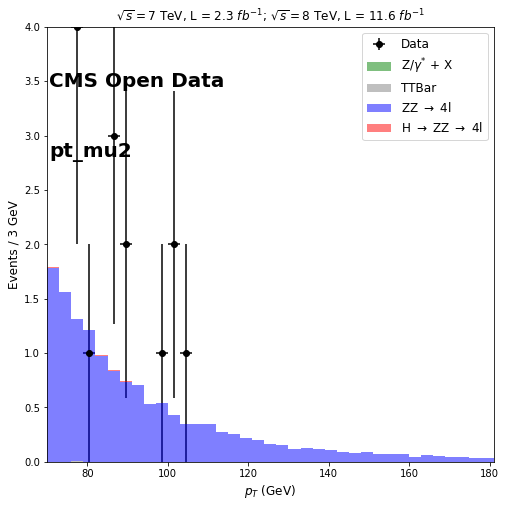

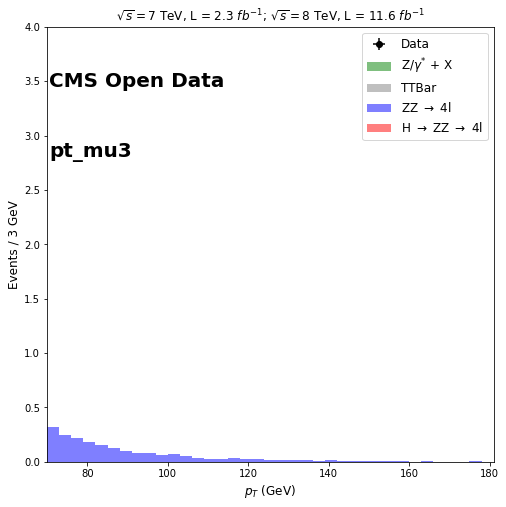

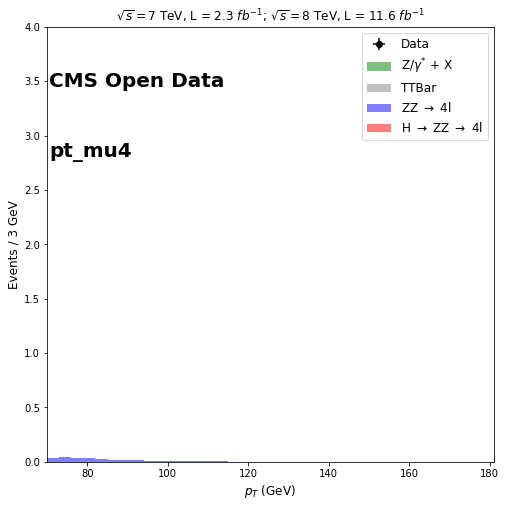

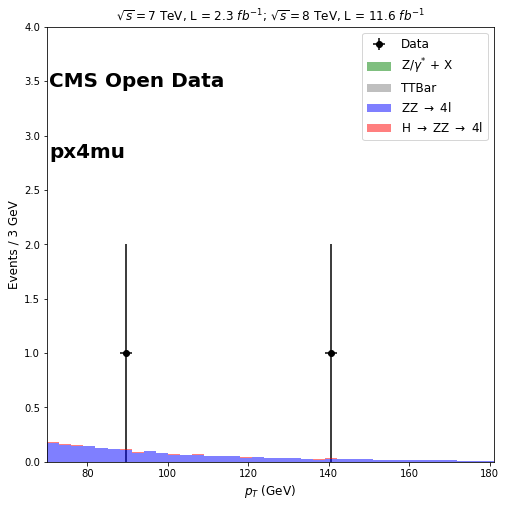

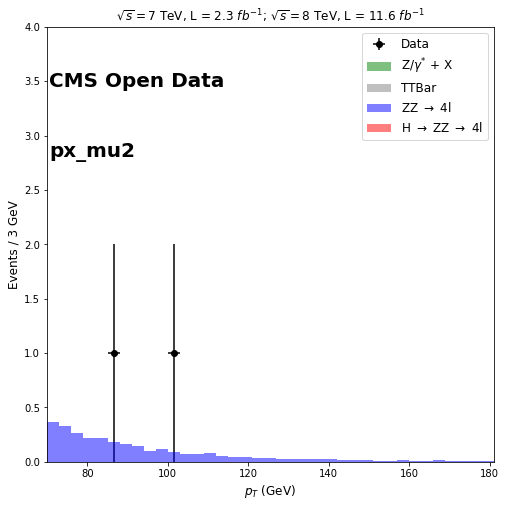

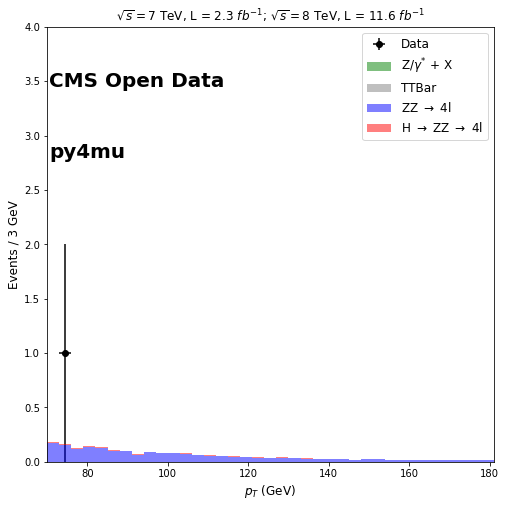

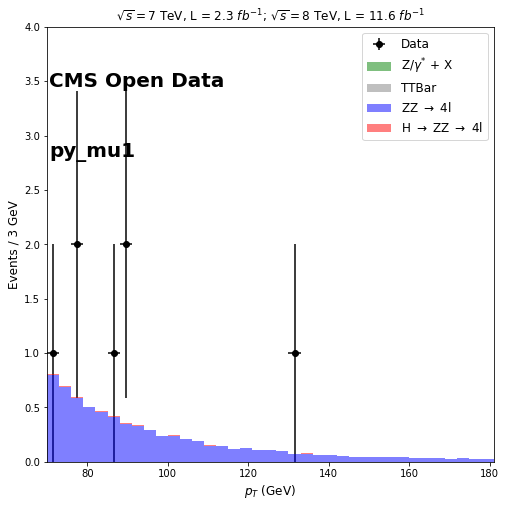

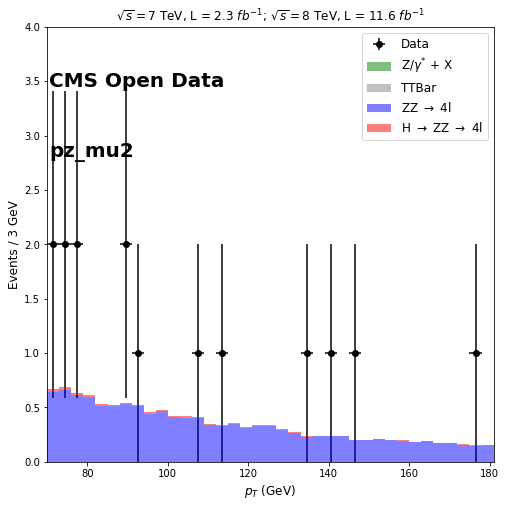

In [27]:
weightsDY_4mu = np.concatenate([weights_DY50_4mu, weights_DY10_4mu], axis=0)

for feature in features_4mu:
    
    ptHZZ11_4mu = mc_4mu.loc[:, feature].values[np.where(mc_4mu.Event.values == "HZZ4mu-11")]
    ptHZZ12_4mu = mc_4mu.loc[:, feature].values[np.where(mc_4mu.Event.values == "HZZ4mu-12")]
    ptZZ11_4mu = mc_4mu.loc[:, feature].values[np.where(mc_4mu.Event.values == "ZZ4mu-11")]
    ptZZ12_4mu = mc_4mu.loc[:, feature].values[np.where(mc_4mu.Event.values == "ZZ4mu-12")]
    ptTTbar11_4mu = mc_4mu.loc[:, feature].values[np.where(mc_4mu.Event.values == "TTBar4mu-11")]
    ptTTbar12_4mu = mc_4mu.loc[:, feature].values[np.where(mc_4mu.Event.values == "TTBar4mu-12")]
    ptDY5011_4mu = mc_4mu.loc[:, feature].values[np.where(mc_4mu.Event.values == "DY504mu-11")]
    ptDY5012_4mu = mc_4mu.loc[:, feature].values[np.where(mc_4mu.Event.values == "DY504mu-12")]
    ptDY1011_4mu = mc_4mu.loc[:, feature].values[np.where(mc_4mu.Event.values == "DY104mu-11")]
    ptDY1012_HT200to400_4mu = mc_4mu.loc[:, feature].values[np.where(mc_4mu.Event.values == "DY10_HT200to400_4mu-12")]
    ptDY1012_HT400toInf_4mu = mc_4mu.loc[:, feature].values[np.where(mc_4mu.Event.values == "DY10_HT400toInf_4mu-12")]

    pt_HZZ_4mu = np.concatenate([ptHZZ11_4mu, ptHZZ12_4mu], axis=0)
    pt_ZZ_4mu = np.concatenate([ptZZ11_4mu, ptZZ12_4mu], axis=0)
    pt_TTBar_4mu = np.concatenate([ptTTbar11_4mu, ptTTbar12_4mu], axis=0)
    pt_DY50_4mu = np.concatenate([ptDY5011_4mu, ptDY5012_4mu], axis=0)
    pt_DY10_4mu = np.concatenate([ptDY1011_4mu, ptDY1012_HT200to400_4mu, ptDY1012_HT400toInf_4mu], axis=0)
    pt_DY_4mu = np.concatenate([pt_DY50_4mu, pt_DY10_4mu], axis=0)
    
    nbins = 37
    
    if "phi" in feature:
        xmin = -4
        xmax = 4
        adj_x = 0.5
        adj_y = -0.5
    elif "eta" in feature:
        xmin = -2.3
        xmax = 2.3
        adj_x = 0.5
        adj_y = -0.5
        nbins = 30
    elif "E_" in feature:
        xmin = 70
        xmax = 181
        adj_x = 0.5
        adj_y = -0.5
        nbins = 30
    elif "p" in feature:
        xmin = 70
        xmax = 181
        adj_x = 0.5
        adj_y = -0.5
    else:
        xmin = 70
        xmax = 181
        adj_x = 13
        adj_y = -2
        
    if "phi" in feature:
        y_max = 12.5
        xlabel = r"$\phi$"
        ylabel = "Events"
    elif "eta" in feature:
        y_max = 12.5
        xlabel = r"$\eta$"
        ylabel = "Events"
    elif "E_" in feature:
        y_max = 7.5
        xlabel = "E (GeV)"
    elif "p" in feature:
        y_max = 4
        xlabel = r"$p_{T}$ (GeV)"
    else:
        y_max = 15
        xlabel = r"$m_{4\mu}$ (GeV)"

    # Computing frequency and bins for Data, and masking the scatter plot
    n_data, bin_edges = np.histogram(data_4mu.loc[:, feature].values, bins=nbins, range=(xmin,xmax))
    data_mask = n_data > 0

    # Computing frequency and bins for MC
    n_HZZ, bin_edges = np.histogram(pt_HZZ_4mu, bins=nbins, range=(xmin,xmax), weights=weights_HZZ_4mu)
    n_ZZ, bin_edges = np.histogram(pt_ZZ_4mu, bins=nbins, range=(xmin,xmax), weights=weights_ZZ_4mu)
    n_TTbar, bin_edges = np.histogram(pt_TTBar_4mu, bins=nbins, range=(xmin,xmax), weights=weights_TTBar_4mu)
    n_DY, bin_edges = np.histogram(pt_DY_4mu, bins=nbins, range=(xmin,xmax), weights=weightsDY_4mu)

    HZZ_mask = n_HZZ > 0
    ZZ_mask = n_ZZ > 0
    TTBar_mask = n_TTbar > 0
    DY_mask = n_DY > 0

    # Computing bin width and x-axis centered values
    width = 1.0*(bin_edges[1] - bin_edges[0])
    center = (bin_edges[:-1] + bin_edges[1:])/2.
    
    if "phi" in feature:
        ylabel = "Events"
    elif "eta" in feature:
        ylabel = "Events"
    else:
        ylabel = f'Events / {int(width)} GeV'

    # Ploting using bar method
    plt.figure(figsize = (8,8))
    plt.errorbar(center[data_mask], n_data[data_mask], yerr=np.sqrt(n_data[data_mask]), xerr=(width/2)*np.ones(n_data[data_mask].size), marker="o", color="black", linestyle='None', label="Data", zorder=1)
    plt.bar(center, n_DY, width=width, align='center', color="g", bottom=n_TTbar, linewidth=0, edgecolor='black', alpha=0.5, label='Z/$\gamma^{*}$ + X')
    plt.bar(center, n_TTbar, width=width, align='center', color="grey", linewidth=0, edgecolor='black', alpha=0.5, label='TTBar')
    plt.bar(center, n_ZZ, width=width, align='center', color="b", bottom=n_TTbar+n_DY, linewidth=0, edgecolor='black', alpha=0.5, label=r'ZZ $\rightarrow$ 4l')
    plt.bar(center, n_HZZ, width=width, align='center', color="r", bottom=n_TTbar+n_DY+n_ZZ, linewidth=0, edgecolor='red', alpha=0.5, label=r'H $\rightarrow$ ZZ $\rightarrow$ 4l', fill=True)
    #plt.plot(center+width/2, n_HZZ, color="r", linewidth=1, label='$m_{H}$ = 125 GeV', drawstyle="steps")
    plt.xlim((xmin,xmax))
    plt.ylim((0, y_max))
    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel(ylabel, fontsize = 12)
    plt.legend(fontsize = 12)
    plt.title('$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize = 12)

    ## -----------------------------
    ## CMS Notation
    ## -----------------------------
    ## Obtenção dos limites do gráfico
    x_begin, x_end = plt.xlim()
    y_begin, y_end = plt.ylim()

    ## Inserção do texto
    plt.text(x_begin + adj_x, y_end + adj_y,\
             'CMS Open Data',\
             horizontalalignment='left',\
             verticalalignment='center',\
             fontsize=20, \
             fontweight='bold')
    
    plt.text(x_begin + adj_x, y_end + adj_y - 0.65,\
             feature,\
             horizontalalignment='left',\
             verticalalignment='center',\
             fontsize=20, \
             fontweight='bold')

    plt.show()
    
    xmin = 70
    xmax = 181

# Hyperparameter Grid Search with XGBOOST

In [10]:
params = {
        'min_child_weight': [1, 10, 50, 100, 200],
        'eta': [0.001, 0.01, 0.05, 0.1],
        'subsample': [0.5, 0.6, 0.8],
        'colsample_bytree': [0.5, 0.6, 0.8],
        'max_depth': [3, 4, 5, 6, 7, 8, 9],
        }

xgb_clas_4mu = XGBClassifier(learning_rate=0.02, n_estimators=3000, objective='binary:logistic', nthread=4)
skf_4mu = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
random_search_4mu = RandomizedSearchCV(
        xgb_clas_4mu, 
        param_distributions=params, 
        n_iter=param_comb, 
        scoring='f1', 
        n_jobs=-1, 
        cv=skf_4mu.split(X_train_4mu,y_train_4mu),
        verbose=3, 
        random_state=random_state
)

random_search_4mu.fit(X_train_4mu, y_train_4mu, sample_weight=weights_train_4mu)
hyperparams_4mu = random_search_4mu.best_params_
bst_classifier_4mu = random_search_4mu.best_estimator_

print(hyperparams_4mu)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  5.8min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 10.4min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 10.5min finished


{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 8, 'eta': 0.05, 'colsample_bytree': 0.8}


# Training XGBOOST Model

In [11]:
xgb_train_4mu = xgb.DMatrix(data=X_train_4mu, label=y_train_4mu, weight=weights_train_4mu, missing=np.nan, feature_names=features_4mu)
classifier_4mu = xgb.train(params=hyperparams_4mu, dtrain=xgb_train_4mu, num_boost_round=3000)

# Feature Importance

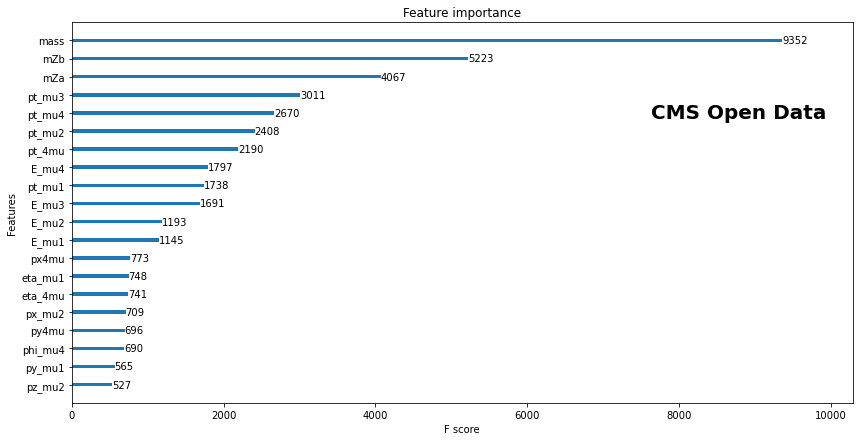

In [126]:
ax = xgb.plot_importance(classifier_4mu, grid=False)
fig = ax.figure

## -----------------------------
## CMS Notation
## -----------------------------

## Inserção do texto
fig.text(0.7, 0.7,\
         'CMS Open Data',\
         horizontalalignment='left',\
         verticalalignment='center',\
         fontsize=20, \
         fontweight='bold')

fig.set_size_inches(14, 7)

# Predicting test data

In [13]:
xgb_test_4mu = xgb.DMatrix(data=X_test_4mu, label=y_test_4mu, weight=weights_test_4mu, missing=np.nan, feature_names=features_4mu)
y_pred_4mu = classifier_4mu.predict(xgb_test_4mu)

df_pred_4mu = X_test_4mu.copy()
df_pred_4mu["Label"] = y_test_4mu
df_pred_4mu["Weights"] = weights_test_4mu
df_pred_4mu["Prediction"] = y_pred_4mu

,E_mu1,E_mu2,E_mu3,E_mu4,eta_4mu,eta_mu1,mZa,mZb,mass,phi_mu4,...,pt_mu3,pt_mu4,px4mu,px_mu2,py4mu,py_mu1,pz_mu2,Label,Weights,Prediction
0,37.751053,56.669484,20.538498,7.814833,-2.573337,-0.156014,48.860108,40.696968,106.445228,-1.917565,...,13.632683,6.673438,2.405605,-6.996566,8.962267,-32.866495,-43.332426,0,0.000150,-0.005141
1,46.140758,60.383068,24.012235,13.542951,1.423523,-0.246168,90.855913,15.863742,141.890872,0.701430,...,18.531540,12.302981,-6.462754,-7.070456,-9.378448,-36.317463,54.335502,0,0.000150,-0.004854
2,60.836638,167.585775,45.853253,182.256827,2.509294,-0.284139,90.344587,89.482710,310.378930,0.888549,...,44.873837,40.769032,-46.778127,-17.690966,-27.171239,31.730467,160.165255,0,0.000824,-0.000706
3,30.677196,22.313819,21.547719,7.418345,1.679376,-0.029713,52.286516,22.480009,80.733355,-2.930082,...,19.262680,6.953184,2.294452,17.618210,4.538845,-20.098736,1.833047,0,0.000824,0.004891
4,71.379394,143.334108,45.174690,35.043750,2.427385,0.161595,91.171350,91.399781,259.966922,-1.271444,...,44.848392,34.603207,17.119443,63.034010,-17.385812,67.880392,125.821734,0,0.000824,0.000383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66779,197.327494,83.437265,87.363605,21.038802,3.695640,2.172976,93.055721,27.622590,127.013171,-1.801378,...,27.433228,7.675602,-11.262581,2.051320,14.369983,-44.349242,72.592102,1,0.000044,0.547269
66780,180.584760,230.725663,19.405256,42.796736,1.523930,-1.785004,89.191441,37.470853,462.076938,0.700945,...,19.030783,8.019168,1.757413,-36.487044,-42.989793,-36.057111,226.510254,0,0.000824,0.016873
66781,64.020417,60.254349,38.925549,105.124275,2.796933,0.706029,93.110318,93.232314,208.147297,3.032167,...,37.933784,30.728668,17.670638,31.750343,-10.550469,4.615923,37.336421,0,0.000150,0.000732
66782,66.625358,116.911187,35.307934,15.622153,3.649019,0.316147,91.198814,83.499033,206.771894,-3.095014,...,35.276974,9.519210,3.264202,37.443215,4.731321,-24.008024,103.866879,0,0.000150,0.001158


[-0.00514054 -0.00485438 -0.00070649 ...  0.00073242  0.001158
  0.01327568]


# Analysing model performance

In [14]:
def model_performance(y_test, y_pred, n=1000):
    '''Routine for compute performance indicators of a given model'''
    thresholds = np.linspace(start = 0, stop = 1, num = n)   ### cut limits
    tp = np.zeros(shape = thresholds.size)                   ### signal selected
    fn = np.zeros(shape = thresholds.size)                   ### signal rejected
    fp = np.zeros(shape = thresholds.size)                   ### background rejected
    tn = np.zeros(shape = thresholds.size)                   ### background selected

    y_pred1 = y_pred[y_test == 1]
    y_pred0 = y_pred[y_test == 0]

    for i,thr in enumerate(thresholds):
        tp[i] = np.where(y_pred1 >= thr)[0].size
        fn[i] = np.where(y_pred1 < thr)[0].size
        fp[i] = np.where(y_pred0 > thr)[0].size
        tn[i] = np.where(y_pred0 <= thr)[0].size

    tpr = tp/(tp + fn)                     ### HEP: Efficiency, IR (Information Retrieval): Recall, Med (Medicine): Sensitivy
    fpr = fp/(fp + tn)                     ### HEP: Background Rejection, IR: -, Med: Specificity
    ppv = tp/(tp + fp)                     ### HEP: Purity, IR: Precision, Med: -
    acc = (tp + tn)/(tp + fn + tn + fp)    ### Accuracy

    return thresholds, fpr, tpr, ppv, acc

# Performance indicators
thresholds_4mu, fpr_4mu, tpr_4mu, ppv_4mu, acc_4mu = model_performance(y_test=y_test_4mu, y_pred=y_pred_4mu)
auc_score_4mu = auc(fpr_4mu, tpr_4mu)

# Selecting indicators based on purity cuts from 10% to 90%
cutflow_4mu = pd.DataFrame()
cutflow_4mu["idx"] = [np.nanargmax(ppv_4mu >= cut) for cut in [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, ppv_4mu[np.nanargmax(ppv_4mu*tpr_4mu)]]]
cutflow_4mu["purity_cut"] = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, ppv_4mu[np.nanargmax(ppv_4mu*tpr_4mu)]]
cutflow_4mu["purity"] = [ppv_4mu[purity] for purity in cutflow_4mu.idx]
cutflow_4mu["threshold"] = [thresholds_4mu[purity] for purity in cutflow_4mu.idx]
cutflow_4mu["efficiency"] = [tpr_4mu[purity] for purity in cutflow_4mu.idx]
cutflow_4mu["bkg_rejection"] = [fpr_4mu[purity] for purity in cutflow_4mu.idx]
cutflow_4mu["accuracy"] = [acc_4mu[purity] for purity in cutflow_4mu.idx]
cutflow_4mu = cutflow_4mu.drop(["idx"], axis = 1)

# Best purity cut base in max(purity*efficiency)%
bstcut_4mu = pd.DataFrame()
bstcut_4mu["idx"] = [np.nanargmax(ppv_4mu >= ppv_4mu[np.nanargmax(ppv_4mu*tpr_4mu)])]
bstcut_4mu["purity_cut"] = [ppv_4mu[np.nanargmax(ppv_4mu*tpr_4mu)]]
bstcut_4mu["purity"] = [ppv_4mu[purity] for purity in bstcut_4mu.idx]
bstcut_4mu["threshold"] = [thresholds_4mu[purity] for purity in bstcut_4mu.idx]
bstcut_4mu["efficiency"] = [tpr_4mu[purity] for purity in bstcut_4mu.idx]
bstcut_4mu["bkg_rejection"] = [fpr_4mu[purity] for purity in bstcut_4mu.idx]
bstcut_4mu["accuracy"] = [acc_4mu[purity] for purity in bstcut_4mu.idx]
bstcut_4mu = bstcut_4mu.drop(["idx"], axis = 1)
thr_4mu = bstcut_4mu.threshold.values[0]

display(cutflow_4mu)
display(bstcut_4mu)

,purity_cut,purity,threshold,efficiency,bkg_rejection,accuracy
0,0.100000,0.184822,0.000000,0.995969,0.530324,0.526369
1,0.200000,0.265126,0.001001,0.995274,0.333042,0.702324
2,0.300000,0.318710,0.002002,0.994718,0.256704,0.770379
3,0.400000,0.418618,0.005005,0.993884,0.166639,0.850653
4,0.500000,0.514424,0.009009,0.991521,0.112989,0.898269
5,0.600000,0.604704,0.014014,0.989853,0.078117,0.929205
6,0.700000,0.705421,0.024024,0.987629,0.049790,0.954241
7,0.800000,0.801000,0.056056,0.979705,0.029384,0.971595
8,0.900000,0.900511,0.284284,0.931054,0.012418,0.981493
9,0.898289,0.898289,0.272272,0.934251,0.012771,0.981523


,purity_cut,purity,threshold,efficiency,bkg_rejection,accuracy
0,0.898289,0.898289,0.272272,0.934251,0.012771,0.981523


# Decision Regions

In [15]:
def check_Xy(X, y, y_int=True):

    # check types
    if not isinstance(X, np.ndarray):
        raise ValueError('X must be a NumPy array. Found %s' % type(X))
    if not isinstance(y, np.ndarray):
        raise ValueError('y must be a NumPy array. Found %s' % type(y))

    if 'int' not in str(y.dtype):
        raise ValueError('y must be an integer array. Found %s. '
                         'Try passing the array as y.astype(np.integer)'
                         % y.dtype)

    if not ('float' in str(X.dtype) or 'int' in str(X.dtype)):
        raise ValueError('X must be an integer or float array. Found %s.'
                         % X.dtype)

    # check dim
    if len(X.shape) != 2:
        raise ValueError('X must be a 2D array. Found %s' % str(X.shape))
    if len(y.shape) > 1:
        raise ValueError('y must be a 1D array. Found %s' % str(y.shape))

    # check other
    if y.shape[0] != X.shape[0]:
        raise ValueError('y and X must contain the same number of samples. '
                         'Got y: %d, X: %d' % (y.shape[0], X.shape[0]))

def format_kwarg_dictionaries(default_kwargs=None, user_kwargs=None,
                              protected_keys=None):
    """Function to combine default and user specified kwargs dictionaries
    Parameters
    ----------
    default_kwargs : dict, optional
        Default kwargs (default is None).
    user_kwargs : dict, optional
        User specified kwargs (default is None).
    protected_keys : array_like, optional
        Sequence of keys to be removed from the returned dictionary
        (default is None).
    Returns
    -------
    formatted_kwargs : dict
        Formatted kwargs dictionary.
    """
    formatted_kwargs = {}
    for d in [default_kwargs, user_kwargs]:
        if not isinstance(d, (dict, type(None))):
            raise TypeError('d must be of type dict or None, but '
                            'got {} instead'.format(type(d)))
        if d is not None:
            formatted_kwargs.update(d)
    if protected_keys is not None:
        for key in protected_keys:
            formatted_kwargs.pop(key, None)

    return formatted_kwargs

def get_feature_range_mask(X, filler_feature_values=None,
                           filler_feature_ranges=None):
    """
    Function that constucts a boolean array to get rid of samples
    in X that are outside the feature range specified by filler_feature_values
    and filler_feature_ranges
    """

    if not isinstance(X, np.ndarray) or not len(X.shape) == 2:
        raise ValueError('X must be a 2D array')
    elif filler_feature_values is None:
        raise ValueError('filler_feature_values must not be None')
    elif filler_feature_ranges is None:
        raise ValueError('filler_feature_ranges must not be None')

    mask = np.ones(X.shape[0], dtype=bool)
    for feature_idx in filler_feature_ranges:
        feature_value = filler_feature_values[feature_idx]
        feature_width = filler_feature_ranges[feature_idx]
        upp_limit = feature_value + feature_width
        low_limit = feature_value - feature_width
        feature_mask = (X[:, feature_idx] > low_limit) & \
                       (X[:, feature_idx] < upp_limit)
        mask = mask & feature_mask

    return mask

def plot_decision_regions(X, y, clf,
                         thr=0.5,
                         feature_index=None,
                         feature_names=None,
                         filler_feature_values=None,
                         filler_feature_ranges=None,
                         ax=None,
                         X_highlight=None,
                         res=None,
                         zoom_factor=1.,
                         legend=1,
                         hide_spines=True,
                         markers="s^oxv<>",
                         colors=('#1f77b4,#ff7f0e,#3ca02c,#d62728,'
                                 '#9467bd,#8c564b,#e377c2,'
                                 '#7f7f7f,#bcbd22,#17becf'),
                         scatter_kwargs=None,
                         contourf_kwargs=None,
                         scatter_highlight_kwargs=None,
                         verbose_jupyter=False):
    
    """Plot decision regions of a classifier.
    
    Please note that this functions assumes that class labels are
    labeled consecutively, e.g,. 0, 1, 2, 3, 4, and 5. If you have class
    labels with integer labels > 4, you may want to provide additional colors
    and/or markers as `colors` and `markers` arguments.
    See http://matplotlib.org/examples/color/named_colors.html for more
    information.
    
    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
        Feature Matrix.
    y : array-like, shape = [n_samples]
        True class labels.
    clf : Classifier object.
        Must have a .predict method.
    thr : Threshold value for probability predict output.
        float (default: 0.5).
    feature_index : array-like (default: (0,) for 1D, (0, 1) otherwise)
        Feature indices to use for plotting. The first index in
        `feature_index` will be on the x-axis, the second index will be
        on the y-axis.
    feature_names : array-like (default: None)
        Feature names to use for constructing XGB DMatrix object from Pandas DataFrame.
    filler_feature_values : dict (default: None)
        Only needed for number features > 2. Dictionary of feature
        index-value pairs for the features not being plotted.
    filler_feature_ranges : dict (default: None)
        Only needed for number features > 2. Dictionary of feature
        index-value pairs for the features not being plotted. Will use the
        ranges provided to select training samples for plotting.
    ax : matplotlib.axes.Axes (default: None)
        An existing matplotlib Axes. Creates
        one if ax=None.
    X_highlight : array-like, shape = [n_samples, n_features] (default: None)
        An array with data points that are used to highlight samples in `X`.
    res : float or array-like, shape = (2,) (default: None)
        This parameter was used to define the grid width,
        but it has been deprecated in favor of
        determining the number of points given the figure DPI and size
        automatically for optimal results and computational efficiency.
        To increase the resolution, it's is recommended to use to provide
        a `dpi argument via matplotlib, e.g., `plt.figure(dpi=600)`.
    zoom_factor : float (default: 1.0)
        Controls the scale of the x- and y-axis of the decision plot.
    hide_spines : bool (default: True)
        Hide axis spines if True.
    legend : int (default: 1)
        Integer to specify the legend location.
        No legend if legend is 0.
    markers : str (default: 's^oxv<>')
        Scatterplot markers.
    colors : str (default: 'red,blue,limegreen,gray,cyan')
        Comma separated list of colors.
    scatter_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib scatter function.
    contourf_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib contourf function.
    scatter_highlight_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib scatter function.
        
    Returns
    ---------
    ax : matplotlib.axes.Axes object
    
    """
    
    check_Xy(X, y, y_int=True)  # Validate X and y arrays
    dim = X.shape[1]
    
    if ax is None:
        ax = plt.gca()
    
    if res is not None:
        warnings.warn("The 'res' parameter has been deprecated."
                      "To increase the resolution, it's is recommended"
                      "to use to provide a `dpi argument via matplotlib,"
                      "e.g., `plt.figure(dpi=600)`.",
                      DeprecationWarning)
        
    plot_testdata = True
    if not isinstance(X_highlight, np.ndarray):
        if X_highlight is not None:
            raise ValueError('X_highlight must be a NumPy array or None')
        else:
            plot_testdata = False
    elif len(X_highlight.shape) < 2:
        raise ValueError('X_highlight must be a 2D array')
        
    if feature_index is not None:
        # Unpack and validate the feature_index values
        if dim == 1:
            raise ValueError(
                'feature_index requires more than one training feature')
        try:
            x_index, y_index = feature_index
        except ValueError:
            raise ValueError(
                'Unable to unpack feature_index. Make sure feature_index '
                'only has two dimensions.')
        try:
            X[:, x_index], X[:, y_index]
        except IndexError:
            raise IndexError(
                'feature_index values out of range. X.shape is {}, but '
                'feature_index is {}'.format(X.shape, feature_index))
    else:
        feature_index = (0, 1)
        x_index, y_index = feature_index
        
    # Extra input validation for higher number of training features
    if dim > 2:
        if filler_feature_values is None:
            raise ValueError('Filler values must be provided when '
                             'X has more than 2 training features.')

        if filler_feature_ranges is not None:
            if not set(filler_feature_values) == set(filler_feature_ranges):
                raise ValueError(
                    'filler_feature_values and filler_feature_ranges must '
                    'have the same keys')

        # Check that all columns in X are accounted for
        column_check = np.zeros(dim, dtype=bool)
        for idx in filler_feature_values:
            column_check[idx] = True
        for idx in feature_index:
            column_check[idx] = True
        if not all(column_check):
            missing_cols = np.argwhere(~column_check).flatten()
            raise ValueError(
                'Column(s) {} need to be accounted for in either '
                'feature_index or filler_feature_values'.format(missing_cols))
            
    marker_gen = cycle(list(markers))

    n_classes = np.unique(y).shape[0]
    colors = colors.split(',')
    colors_gen = cycle(colors)
    colors = [next(colors_gen) for c in range(n_classes)]

    # Get minimum and maximum
    x_min, x_max = (X[:, x_index].min() - 1./zoom_factor,
                    X[:, x_index].max() + 1./zoom_factor)
    if dim == 1:
        y_min, y_max = -1, 1
    else:
        y_min, y_max = (X[:, y_index].min() - 1./zoom_factor,
                        X[:, y_index].max() + 1./zoom_factor)

    xnum, ynum = plt.gcf().dpi * plt.gcf().get_size_inches()
    xnum, ynum = floor(xnum), ceil(ynum)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=xnum),
                         np.linspace(y_min, y_max, num=ynum))

    if dim == 1:
        X_predict = np.array([xx.ravel()]).T
    else:
        X_grid = np.array([xx.ravel(), yy.ravel()]).T
        X_predict = np.zeros((X_grid.shape[0], dim))
        X_predict[:, x_index] = X_grid[:, 0]
        X_predict[:, y_index] = X_grid[:, 1]
        if dim > 2:
            for feature_idx in filler_feature_values:
                X_predict[:, feature_idx] = filler_feature_values[feature_idx]
                
    X_predict = X_predict.astype(X.dtype)
    X_predict = pd.DataFrame(X_predict, columns=feature_names)
    
    if verbose_jupyter is True:
        display(X_predict)
    
    X_predict = xgb.DMatrix(data=X_predict, missing=np.nan, feature_names=feature_names)
    Z = clf.predict(X_predict)
    Z = np.array([1 if i >= thr else 0 for i in Z])
    Z = Z.reshape(xx.shape)
    
    # Plot decisoin region
    # Make sure contourf_kwargs has backwards compatible defaults
    contourf_kwargs_default = {'alpha': 0.45, 'antialiased': True}
    contourf_kwargs = format_kwarg_dictionaries(
                        default_kwargs=contourf_kwargs_default,
                        user_kwargs=contourf_kwargs,
                        protected_keys=['colors', 'levels'])
    
    cset = ax.contourf(xx, yy, Z,
                       colors=colors,
                       levels=np.arange(Z.max() + 2) - 0.5,
                       **contourf_kwargs)

    ax.contour(xx, yy, Z, cset.levels,
               colors='k',
               linewidths=0.5,
               antialiased=True)

    ax.axis([xx.min(), xx.max(), yy.min(), yy.max()])

    # Scatter training data samples
    # Make sure scatter_kwargs has backwards compatible defaults
    scatter_kwargs_default = {'alpha': 0.8, 'edgecolor': 'black'}
    scatter_kwargs = format_kwarg_dictionaries(
                        default_kwargs=scatter_kwargs_default,
                        user_kwargs=scatter_kwargs,
                        protected_keys=['c', 'marker', 'label'])
    for idx, c in enumerate(np.unique(y)):
        if dim == 1:
            y_data = [0 for i in X[y == c]]
            x_data = X[y == c]
        elif dim == 2:
            y_data = X[y == c, y_index]
            x_data = X[y == c, x_index]
        elif dim > 2 and filler_feature_ranges is not None:
            class_mask = y == c
            feature_range_mask = get_feature_range_mask(
                            X, filler_feature_values=filler_feature_values,
                            filler_feature_ranges=filler_feature_ranges)
            y_data = X[class_mask & feature_range_mask, y_index]
            x_data = X[class_mask & feature_range_mask, x_index]
        else:
            continue

        ax.scatter(x=x_data,
                   y=y_data,
                   c=colors[idx],
                   marker=next(marker_gen),
                   label="signal" if c == 1 else "background",
                   **scatter_kwargs)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if dim == 1:
        ax.axes.get_yaxis().set_ticks([])

    if plot_testdata:
        if dim == 1:
            x_data = X_highlight
            y_data = [0 for i in X_highlight]
        elif dim == 2:
            x_data = X_highlight[:, x_index]
            y_data = X_highlight[:, y_index]
        else:
            feature_range_mask = get_feature_range_mask(
                    X_highlight, filler_feature_values=filler_feature_values,
                    filler_feature_ranges=filler_feature_ranges)
            y_data = X_highlight[feature_range_mask, y_index]
            x_data = X_highlight[feature_range_mask, x_index]

        # Make sure scatter_highlight_kwargs backwards compatible defaults
        scatter_highlight_defaults = {'c': '',
                                      'edgecolor': 'black',
                                      'alpha': 1.0,
                                      'linewidths': 1,
                                      'marker': 'o',
                                      's': 80}
        scatter_highlight_kwargs = format_kwarg_dictionaries(
                                    default_kwargs=scatter_highlight_defaults,
                                    user_kwargs=scatter_highlight_kwargs)
        ax.scatter(x_data,
                   y_data,
                   **scatter_highlight_kwargs)

    if legend:
        if dim > 2 and filler_feature_ranges is None:
            pass
        else:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels,
                      framealpha=0.3, scatterpoints=1, loc=legend)

    return ax

,E_mu1,E_mu2,E_mu3,E_mu4,eta_4mu,eta_mu1,mZa,mZb,mass,phi_mu4,pt_4mu,pt_mu1,pt_mu2,pt_mu3,pt_mu4,px4mu,px_mu2,py4mu,py_mu1,pz_mu2
0,82.749367,56.478632,34.215782,21.392499,-9.978889,0.019565,82.742146,28.975717,69.015291,-0.022591,39.199719,49.825308,33.173304,20.014541,12.143232,-0.232376,-0.216635,-0.065421,-0.201468,-0.281831
1,82.749367,56.478632,34.215782,21.392499,-9.978889,0.019565,82.742146,28.975717,72.162967,-0.022591,39.199719,49.825308,33.173304,20.014541,12.143232,-0.232376,-0.216635,-0.065421,-0.201468,-0.281831
2,82.749367,56.478632,34.215782,21.392499,-9.978889,0.019565,82.742146,28.975717,75.310643,-0.022591,39.199719,49.825308,33.173304,20.014541,12.143232,-0.232376,-0.216635,-0.065421,-0.201468,-0.281831
3,82.749367,56.478632,34.215782,21.392499,-9.978889,0.019565,82.742146,28.975717,78.458319,-0.022591,39.199719,49.825308,33.173304,20.014541,12.143232,-0.232376,-0.216635,-0.065421,-0.201468,-0.281831
4,82.749367,56.478632,34.215782,21.392499,-9.978889,0.019565,82.742146,28.975717,81.605995,-0.022591,39.199719,49.825308,33.173304,20.014541,12.143232,-0.232376,-0.216635,-0.065421,-0.201468,-0.281831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124411,82.749367,56.478632,34.215782,21.392499,9.706675,0.019565,82.742146,28.975717,1413.073001,-0.022591,39.199719,49.825308,33.173304,20.014541,12.143232,-0.232376,-0.216635,-0.065421,-0.201468,-0.281831
124412,82.749367,56.478632,34.215782,21.392499,9.706675,0.019565,82.742146,28.975717,1416.220677,-0.022591,39.199719,49.825308,33.173304,20.014541,12.143232,-0.232376,-0.216635,-0.065421,-0.201468,-0.281831
124413,82.749367,56.478632,34.215782,21.392499,9.706675,0.019565,82.742146,28.975717,1419.368353,-0.022591,39.199719,49.825308,33.173304,20.014541,12.143232,-0.232376,-0.216635,-0.065421,-0.201468,-0.281831
124414,82.749367,56.478632,34.215782,21.392499,9.706675,0.019565,82.742146,28.975717,1422.516030,-0.022591,39.199719,49.825308,33.173304,20.014541,12.143232,-0.232376,-0.216635,-0.065421,-0.201468,-0.281831


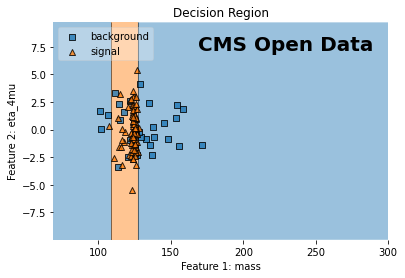

E_mu1 = 82.74936738081159 +- 50.08494026371779
E_mu2 = 56.478632411579866 +- 34.02585686695074
E_mu3 = 34.21578158707683 +- 21.233810690290216
E_mu4 = 21.392498929895744 +- 14.3477511023531
eta_mu1 = 0.019565353981926527 +- 1.055357637410147
mZa = 82.74214608503033 +- 11.149120878200312
mZb = 28.975716933422376 +- 9.917885140348828
phi_mu4 = -0.022590574080143335 +- 1.8123829216337126
pt_4mu = 39.19971883745138 +- 40.66175916909404
pt_mu1 = 49.82530780523924 +- 17.754176688199443
pt_mu2 = 33.17330434861235 +- 9.605547753915605
pt_mu3 = 20.01454060429628 +- 6.529405945793246
pt_mu4 = 12.143231875571006 +- 4.7005417273368835
px4mu = -0.23237635613792362 +- 39.20711518017296
px_mu2 = -0.2166351191960759 +- 24.38783038008682
py4mu = -0.06542052958043718 +- 40.653910713395234
py_mu1 = -0.20146788003100527 +- 37.38719520161217
pz_mu2 = -0.2818314909231592 +- 56.16733564049414


In [133]:
fig, ax = plt.subplots()
y = y_test_4mu
X = X_test_4mu.values
clf = classifier_4mu
thr = thr_4mu
dim = X.shape[1]
feature_names = features_4mu
feature_index = (np.where(feature_names == "mass")[0][0], np.where(feature_names == "eta_4mu")[0][0])
filler_feature_values = {k: X[y == 1][:,k].mean() for k in range(dim) if k not in feature_index}
filler_feature_ranges = {k: X[y == 1][:,k].std() for k in range(dim) if k not in feature_index}

plot_decision_regions(X, y, clf=clf, thr=thr,
                      feature_index=feature_index,
                      feature_names=feature_names,
                      filler_feature_values=filler_feature_values,
                      filler_feature_ranges=filler_feature_ranges,
                      legend=2, ax=ax, verbose_jupyter=True)

## -----------------------------
## CMS Notation
## -----------------------------
## Obtenção dos limites do gráfico
x_begin, x_end = plt.xlim()
y_begin, y_end = plt.ylim()

## Ajuste fino da posição
## caso o texto fique muito alto/baixo
adj_x = 100
adj_y = -2

## Inserção do texto
plt.text(x_begin + adj_x, y_end + adj_y,\
         'CMS Open Data',\
         horizontalalignment='left',\
         verticalalignment='center',\
         fontsize=20, \
         fontweight='bold')

ax.set_xlim(right=300)
ax.set_xlabel(f"Feature 1: {features_4mu[feature_index[0]]}")
ax.set_ylabel(f"Feature 2: {features_4mu[feature_index[1]]}")
ax.set_title("Decision Region")
plt.show()

for idx in filler_feature_values.keys():
    print(f"{features_4mu[idx]} = {filler_feature_values[idx]} +- {filler_feature_ranges[idx]}")

# Plotting performance indicators

# ROC

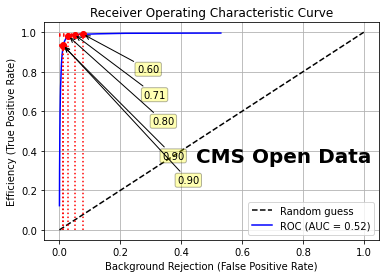

In [184]:
def plot_roc_curve(fpr, tpr, selection, auc=None, fpath=None, fname=None):
    '''Routine for plotting ROC (Receiver Operating Characteristic) Curve'''
    plt.plot([0, 1], [0, 1], linestyle = "--", color = "black", label = "Random guess")
    
    if auc is not None:
        label = "ROC (AUC = {:.2f})".format(auc)
    else:
        label = "ROC"
        
    plt.plot(fpr, tpr, linestyle="-", color="blue", label=label)
    
    ## Boolean para definir a rotação da seta
    arrow_coord = (50, -15)
    
    for fpr, tpr, ppv in zip(selection.bkg_rejection, selection.efficiency, selection.purity):
        if ppv >= 0.6:

            arrow_coor_x, arrow_coor_y = arrow_coord
            arrow_coord = (arrow_coor_x+15, arrow_coor_y-25)
            
            plt.plot([fpr, fpr], [0, tpr], color = "r", linestyle = ":")
            plt.plot([0, fpr], [tpr, tpr], color = "r", linestyle = ":")
            plt.plot([fpr], [tpr], "ro")
            plt.annotate("{:.2f}".format(ppv), (fpr, tpr),\
                         xytext=arrow_coord, textcoords='offset points', ha='center',\
                         va='bottom', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),\
                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'))

    ## -----------------------------
    ## CMS Notation
    ## -----------------------------
    ## Obtenção dos limites do gráfico
    x_begin, x_end = plt.xlim()
    y_begin, y_end = plt.ylim()

    ## Ajuste fino da posição
    ## caso o texto fique muito alto/baixo
    adj_x = 0.5
    adj_y = -0.68

    ## Inserção do texto
    plt.text(x_begin + adj_x, y_end + adj_y,\
             'CMS Open Data',\
             horizontalalignment='left',\
             verticalalignment='center',\
             fontsize=20, \
             fontweight='bold')    
        
    plt.grid(True)
    plt.title("Receiver Operating Characteristic Curve")
    plt.xlabel("Background Rejection (False Positive Rate)")
    plt.ylabel("Efficiency (True Positive Rate)")
    plt.legend()
    if fpath and fname:
        plt.savefig(fpath + fname)
    plt.show()
    plt.close()
    
plot_roc_curve(fpr = fpr_4mu, tpr = tpr_4mu, selection = cutflow_4mu, auc = auc_score_4mu)

# PRC

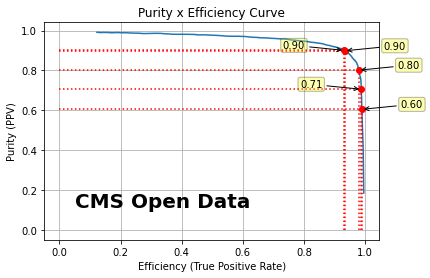

In [174]:
def plot_pr_curve(tpr, ppv, selection, fpath=None, fname=None):
    '''Routine for plotting PR (Purity vs Efficiency) Curve'''
    plt.plot(tpr, ppv, linestyle = "-")
    
    ## Boolean para definir a rotação da seta
    rotate_arrow_right = True
    
    for ppv, tpr in zip(selection.purity, selection.efficiency):
        if ppv >= 0.6:
            
            ## Define a coordenada do texto (right/left)
            if rotate_arrow_right:
                arrow_coord = (50, 0)
            else:
                arrow_coord = (-50, 0)
            
            ## Inverte a rotação para cada iteração
            rotate_arrow_right = not rotate_arrow_right
            
            plt.plot([tpr, tpr], [0, ppv], color = "r", linestyle = ":")
            plt.plot([0, tpr], [ppv, ppv], color = "r", linestyle = ":")
            plt.plot([tpr], [ppv], "ro")
            plt.annotate("{:.2f}".format(ppv), (tpr, ppv),\
                         xytext=arrow_coord, textcoords='offset points', ha='center',\
                         va='bottom', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),\
                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'))

    ## -----------------------------
    ## CMS Notation
    ## -----------------------------
    ## Obtenção dos limites do gráfico
    x_begin, x_end = plt.xlim()
    y_begin, y_end = plt.ylim()

    ## Ajuste fino da posição
    ## caso o texto fique muito alto/baixo
    adj_x = 0.1
    adj_y = -0.9

    ## Inserção do texto
    plt.text(x_begin + adj_x, y_end + adj_y,\
             'CMS Open Data',\
             horizontalalignment='left',\
             verticalalignment='center',\
             fontsize=20, \
             fontweight='bold')
            
    plt.grid(True)
    plt.title("Purity x Efficiency Curve")
    plt.xlabel("Efficiency (True Positive Rate)")
    plt.ylabel("Purity (PPV)")
    if fpath and fname:
        plt.savefig(fpath + fname)
    plt.show()
    plt.close()
    
plot_pr_curve(tpr = tpr_4mu, ppv = ppv_4mu, selection = cutflow_4mu)

# PRRC

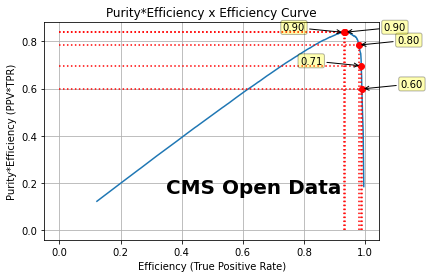

In [169]:
def plot_prr_curve(tpr, ppv, selection, fpath=None, fname=None):
    '''Routine for plotting PRR (Purity*Efficiency vs Efficiency) Curve'''
    plt.plot(tpr, tpr*ppv)
    
    ## Boolean para definir a rotação da seta
    rotate_arrow_right = True  
    
    for ppv, tpr in zip(selection.purity, selection.efficiency):
        if ppv >= 0.6:
            
            ## Define a coordenada do texto (right/left)
            if rotate_arrow_right:
                arrow_coord = (50, 0)
            else:
                arrow_coord = (-50, 0)
            
            ## Inverte a rotação para cada iteração
            rotate_arrow_right = not rotate_arrow_right
            
            plt.plot([tpr, tpr], [0, tpr*ppv], color = "r", linestyle = ":")
            plt.plot([0, tpr], [tpr*ppv, tpr*ppv], color = "r", linestyle = ":")
            plt.plot([tpr], [tpr*ppv], "ro")
            plt.annotate("{:.2f}".format(ppv), (tpr, tpr*ppv),\
                         xytext=arrow_coord, textcoords='offset points', ha='center',\
                         va='bottom', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),\
                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'))

    ## -----------------------------
    ## CMS Notation
    ## -----------------------------
    ## Obtenção dos limites do gráfico
    x_begin, x_end = plt.xlim()
    y_begin, y_end = plt.ylim()

    ## Ajuste fino da posição
    ## caso o texto fique muito alto/baixo
    adj_x = 0.4
    adj_y = -0.7

    ## Inserção do texto
    plt.text(x_begin + adj_x, y_end + adj_y,\
             'CMS Open Data',\
             horizontalalignment='left',\
             verticalalignment='center',\
             fontsize=20, \
             fontweight='bold')
            
    plt.grid(True)
    plt.title("Purity*Efficiency x Efficiency Curve")
    plt.xlabel("Efficiency (True Positive Rate)")
    plt.ylabel("Purity*Efficiency (PPV*TPR)")
    if fpath and fname:
        plt.savefig(fpath + fname)
    plt.show()
    plt.close()

plot_prr_curve(tpr = tpr_4mu, ppv = ppv_4mu, selection = cutflow_4mu)

# PRRC Zoomed

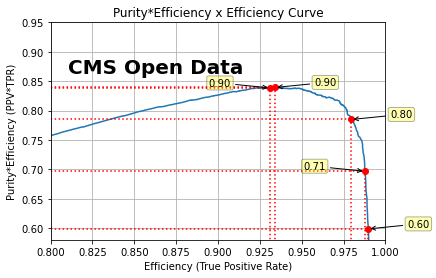

In [201]:
def plot_prr_curve_zoomed(tpr, ppv, selection, fpath=None, fname=None):
    '''Routine for plotting PRR (Purity*Efficiency vs Efficiency) Curve'''
    plt.plot(tpr, tpr*ppv)
    
    ## Boolean para definir a rotação da seta
    rotate_arrow_right = True    
    
    for ppv, tpr in zip(selection.purity, selection.efficiency):
        if ppv >= 0.6:
            
            ## Define a coordenada do texto (right/left)
            if rotate_arrow_right:
                arrow_coord = (50, 0)
            else:
                arrow_coord = (-50, 0)
            
            ## Inverte a rotação para cada iteração
            rotate_arrow_right = not rotate_arrow_right
            
            plt.plot([tpr, tpr], [0, tpr*ppv], color = "r", linestyle = ":")
            plt.plot([0, tpr], [tpr*ppv, tpr*ppv], color = "r", linestyle = ":")
            plt.plot([tpr], [tpr*ppv], "ro")
            plt.annotate("{:.2f}".format(ppv), (tpr, tpr*ppv),\
                         xytext=arrow_coord, textcoords='offset points', ha='center',\
                         va='bottom', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),\
                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'))
            
    ## -----------------------------
    ## CMS Notation
    ## -----------------------------
    ## Obtenção dos limites do gráfico
    x_begin, x_end = plt.xlim()
    y_begin, y_end = plt.ylim()

    ## Ajuste fino da posição
    ## caso o texto fique muito alto/baixo
    adj_x = 0.86
    adj_y = -0.009

    ## Inserção do texto
    plt.text(x_begin + adj_x, y_end + adj_y,\
             'CMS Open Data',\
             horizontalalignment='left',\
             verticalalignment='center',\
             fontsize=20, \
             fontweight='bold')
            
    plt.grid(True)
    plt.xlim(0.8, 1)
    plt.ylim(0.58, 0.95)
    plt.title("Purity*Efficiency x Efficiency Curve")
    plt.xlabel("Efficiency (True Positive Rate)")
    plt.ylabel("Purity*Efficiency (PPV*TPR)")
    if fpath and fname:
        plt.savefig(fpath + fname)
    plt.show()
    plt.close()
    
plot_prr_curve_zoomed(tpr = tpr_4mu, ppv = ppv_4mu, selection = cutflow_4mu)

# PRATC

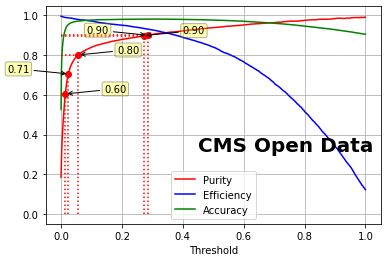

In [161]:
def plot_prat_curve(tpr, ppv, acc, thresholds, selection, fpath=None, fname=None):
    '''Routine for plotting PRAT ({Purity, Efficiency, Accucary} vs Threshold) Curve '''
    plt.plot(thresholds, ppv, color = "red", label = "Purity")
    plt.plot(thresholds, tpr, color = "blue", label = "Efficiency")
    plt.plot(thresholds, acc, color = "green", label = "Accuracy")
    
    ## Boolean para definir a rotação da seta
    rotate_arrow_right = True
    
    for thr, ppv, tpr, acc in zip(selection.threshold, selection.purity, selection.efficiency, selection.accuracy):
        if ppv >= 0.6:
            
            ## Define a coordenada do texto (right/left)
            if rotate_arrow_right:
                arrow_coord = (50, 0)
            else:
                arrow_coord = (-50, 0)
            
            ## Inverte a rotação para cada iteração
            rotate_arrow_right = not rotate_arrow_right
            
            plt.plot([0, thr], [ppv, ppv], color = "red", linestyle = ":")
            plt.plot([thr, thr], [0, ppv], color = "red", linestyle = ":")
            plt.plot([thr], [ppv], "ro")
            plt.annotate("{:.2f}".format(ppv), (thr, ppv),\
                         xytext=arrow_coord, textcoords='offset points', ha='center',\
                         va='bottom', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),\
                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'))

    ## -----------------------------
    ## CMS Notation
    ## -----------------------------
    ## Obtenção dos limites do gráfico
    x_begin, x_end = plt.xlim()
    y_begin, y_end = plt.ylim()

    ## Ajuste fino da posição
    ## caso o texto fique muito alto/baixo
    adj_x = 0.5
    adj_y = -0.7

    ## Inserção do texto
    plt.text(x_begin + adj_x, y_end + adj_y,\
             'CMS Open Data',\
             horizontalalignment='left',\
             verticalalignment='center',\
             fontsize=20, \
             fontweight='bold')
            
    plt.xlabel("Threshold")
    plt.legend()
    plt.grid(True)
    if fpath and fname:
        plt.savefig(fpath + fname)
    plt.show()
    plt.close()
    
plot_prat_curve(tpr = tpr_4mu, ppv = ppv_4mu, acc = acc_4mu, thresholds = thresholds_4mu, selection = cutflow_4mu)

# Visualizing predictions

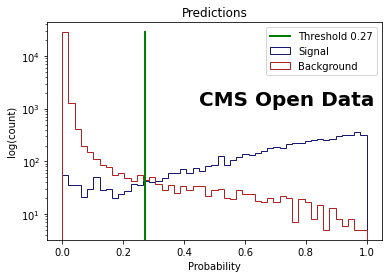

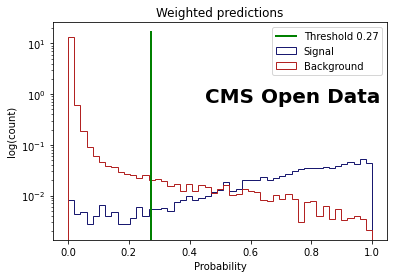

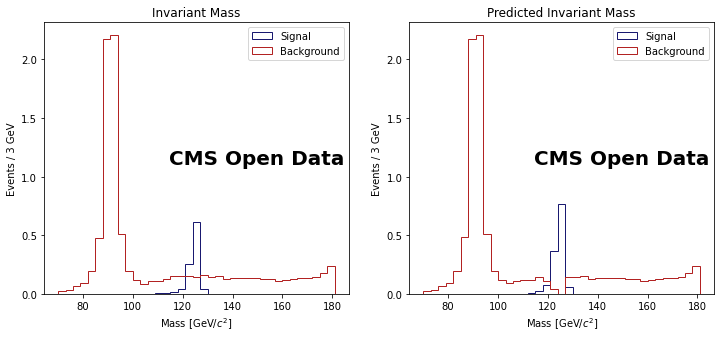

In [251]:
def plot_predictions_with_cut(y_pred, y_test, cut, nbins=np.linspace(0,1,50), rang=(0, 1), df_pred=None, fpath=None, fname=None):
    '''Routine for plotting (probabilities) predictions with a given cut in x-axis'''
    if df_pred is None:
        signal = plt.hist(y_pred[np.where(y_test == 1)], bins=nbins, range=rang, histtype="step", color="midnightblue", label="Signal")
        background = plt.hist(y_pred[np.where(y_test == 0)], bins=nbins, range=rang, histtype="step", color="firebrick", label="Background")
    else:
        signal = plt.hist(df_pred.Prediction.values[np.where(df_pred.Label.values == 1)], weights=df_pred.Weights.values[np.where(df_pred.Label.values == 1)], bins=nbins, range=rang, histtype="step", color="midnightblue", label="Signal")
        background = plt.hist(df_pred.Prediction.values[np.where(df_pred.Label.values == 0)], weights=df_pred.Weights.values[np.where(df_pred.Label.values == 0)], bins=nbins, range=rang, histtype="step", color="firebrick", label="Background") 
    max_signal = np.amax(signal[0])
    max_background = np.amax(background[0])
    max_y_cut = max([max_signal, max_background]) + 3
    plt.plot([cut,cut], [0, max_y_cut], label = "Threshold {:.2f}".format(cut), color = "green", linewidth = 2)
    
    ## -----------------------------
    ## CMS Notation
    ## -----------------------------
    ## Obtenção dos limites do gráfico
    x_begin, x_end = plt.xlim()
    y_begin, y_end = plt.ylim()
    
    ## Ajuste fino da posição
    ## caso o texto fique muito alto/baixo
    adj_x = 0.5

    ## Inserção do texto
    plt.text(x_begin + adj_x, y_end/20,\
             'CMS Open Data',\
             horizontalalignment='left',\
             verticalalignment='center',\
             fontsize=20, \
             fontweight='bold')
    
    plt.xlabel("Probability")
    plt.ylabel("log(count)")
    if df_pred is None:
        plt.yscale("log")
        plt.title("Predictions")
    else:
        plt.yscale("log")
        plt.title("Weighted predictions")
    plt.legend()
    if fpath and fname:
        plt.savefig(fpath + fname)
    plt.show()
    plt.close()
    
def plot_mass_prediction(x_test, y_pred, y_test, cut, nbins=np.linspace(0,800,50), rang=(0, 1), fpath=None, fname=None):
    '''Routine for plotting mass predictions of ...'''
    true_signal = x_test[y_test == 1].mass.values
    true_background = x_test[y_test == 0].mass.values
    pred_signal = x_test[y_pred >= cut].mass.values
    pred_background = x_test[y_pred < cut].mass.values

    plt.figure(figsize = (12,5))
    plt.subplot(1,2,1)
    plt.hist(true_signal, bins = nbins, range = rang, histtype = "step", color = "midnightblue", label = "True signal")
    plt.hist(true_background, bins = nbins, range = rang, histtype = "step", color = "firebrick", label = "True background")
    plt.title("NOT WEIGHTED")
    plt.xlabel("mass4mu")
    plt.ylabel("Events per bin")
    plt.legend()
    plt.subplot(1,2,2)
    plt.hist(pred_signal, bins = nbins, range = rang, histtype = "step", color = "midnightblue", label = "Predicted signal")
    plt.hist(pred_background, bins = nbins, range = rang, histtype = "step", color = "firebrick", label = "Predicted background")
    plt.title("NOT WEIGHTED")
    plt.xlabel("mass4mu")
    plt.ylabel("Events per bin")
    plt.legend()
    if fpath and fname:
        plt.savefig(fpath + fname)
    plt.show()
    plt.close()
    
def plot_weighted_mass_prediction(x_test, y_pred, y_test, cut, weights, nbins=np.linspace(0,800,50), rang=(0, 1), fpath=None, fname=None):
    '''Routine for plotting weighted mass predictions of Atlas Higgs dataset from Kaggle competition'''
    true_signal = x_test[y_test == 1].mass.values
    true_background = x_test[y_test == 0].mass.values
    pred_signal = x_test[y_pred >= cut].mass.values
    pred_background = x_test[y_pred < cut].mass.values

    plt.figure(figsize = (12,5))
    plt.subplot(1,2,1)
    plt.hist(true_signal, bins=nbins, weights=weights[y_test == 1], range=rang, histtype="step", color="midnightblue", label="Signal")
    plt.hist(true_background, bins=nbins, weights=weights[y_test == 0], range=rang, histtype="step", color="firebrick", label="Background")
    
    ## -----------------------------
    ## CMS Notation
    ## -----------------------------
    ## Obtenção dos limites do gráfico
    x_begin, x_end = plt.xlim()
    y_begin, y_end = plt.ylim()
    
    ## Ajuste fino da posição
    ## caso o texto fique muito alto/baixo
    adj_x = 50
    adj_y = -0.7

    ## Inserção do texto
    plt.text(x_begin + adj_x, (y_end + y_begin)/2,\
             'CMS Open Data',\
             horizontalalignment='left',\
             verticalalignment='center',\
             fontsize=20, \
             fontweight='bold')
    
    plt.title("Invariant Mass")
    plt.xlabel("Mass [GeV/$c^{2}$]")
    plt.ylabel("Events / 3 GeV")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.hist(pred_signal, bins=nbins, weights=weights[y_pred >= cut], range=rang, histtype="step", color="midnightblue", label="Signal")
    plt.hist(pred_background, bins=nbins, weights=weights[y_pred <= cut], range=rang, histtype="step", color="firebrick", label="Background")
    
    ## -----------------------------
    ## CMS Notation
    ## -----------------------------
    ## Obtenção dos limites do gráfico
    x_begin, x_end = plt.xlim()
    y_begin, y_end = plt.ylim()
    
    ## Ajuste fino da posição
    ## caso o texto fique muito alto/baixo
    adj_x = 50
    adj_y = -0.7

    ## Inserção do texto
    plt.text(x_begin + adj_x, (y_end + y_begin)/2,\
             'CMS Open Data',\
             horizontalalignment='left',\
             verticalalignment='center',\
             fontsize=20, \
             fontweight='bold')
    
    plt.title("Predicted Invariant Mass")
    plt.xlabel("Mass [GeV/$c^{2}$]")
    plt.ylabel("Events / 3 GeV")
    plt.legend()
    if fpath and fname:
        plt.savefig(fpath + fname)
    plt.show()
    plt.close()
    
plot_predictions_with_cut(y_pred=y_pred_4mu, y_test=y_test_4mu, cut=thr_4mu, nbins=np.linspace(0,1,50), rang=(0, 1))
plot_predictions_with_cut(df_pred=df_pred_4mu, y_pred=y_pred_4mu, y_test=y_test_4mu, cut=thr_4mu, nbins=np.linspace(0,1,50), rang=(0, 1))
# plot_mass_prediction(x_test=X_test_4mu, y_pred=y_pred_4mu, y_test=y_test_4mu, cut=thr, nbins=nbins, rang=(xmin, xmax))
plot_weighted_mass_prediction(x_test=X_test_4mu, y_pred=y_pred_4mu, y_test=y_test_4mu, cut=thr_4mu, weights=weights_test_4mu, nbins=nbins, rang=(xmin, xmax))

# Model summary

In [26]:
print("The following threshold was chosen based on maximizing ppv*tpr and it leads to the following performance indicators\n")
print(f"Threshold: {thr_4mu}")
print(f"Purity: {bstcut_4mu.purity.values[0]}")
print(f"Efficiency: {bstcut_4mu.efficiency.values[0]}")
print(f"Background Rejection: {bstcut_4mu.bkg_rejection.values[0]}")
print(f"Accuracy: {bstcut_4mu.accuracy.values[0]}")

print("\nFraction of signal in test sample {}".format(len(np.where(y_test_4mu == 1)[0])/len(y_test_4mu)))
print("Fraction of signal in predicted sample {}\n".format(len(np.where(y_pred_4mu >= thr_4mu)[0])/len(y_pred_4mu)))

The following threshold was chosen based on maximizing ppv*tpr and it leads to the following performance indicators

Threshold: 0.27227227227227224
Purity: 0.8982892274792836
Efficiency: 0.9342507645259939
Background Rejection: 0.012770599093807686
Accuracy: 0.9815225203641591

Fraction of signal in test sample 0.10772041207474845
Fraction of signal in predicted sample 0.11203282223287014



# Predicting real data

['E_mu1' 'E_mu2' 'E_mu3' 'E_mu4' 'eta_4mu' 'eta_mu1' 'mZa' 'mZb' 'mass'
 'phi_mu4' 'pt_4mu' 'pt_mu1' 'pt_mu2' 'pt_mu3' 'pt_mu4' 'px4mu' 'px_mu2'
 'py4mu' 'py_mu1' 'pz_mu2']


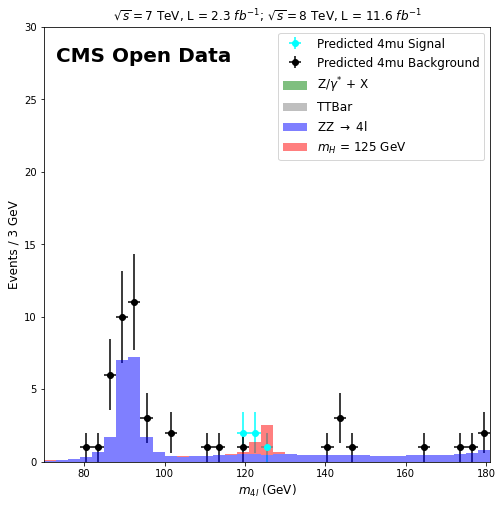

In [231]:
X_4mu = data_4mu[features_4mu]
xgb_real_4mu = xgb.DMatrix(data=X_4mu, label=None, missing=np.nan, feature_names=features_4mu)
y_4mu = classifier_4mu.predict(xgb_real_4mu)
bkg_4mu = X_4mu[y_4mu < thr_4mu]
sig_4mu = X_4mu[y_4mu >= thr_4mu]

# Computing frequency and bins for Data, and masking th-999.0e scatter plot
n_sig4mu_data, bin_sig4mu_edges = np.histogram(sig_4mu.mass.values, bins = nbins, range = (xmin,xmax))
mask_sig4mu = n_sig4mu_data > 0

n_bkg4mu_data, bin_bkg4mu_edges = np.histogram(bkg_4mu.mass.values, bins = nbins, range = (xmin,xmax))
mask_bkg4mu = n_bkg4mu_data > 0

# Computing frequency and bins for MC
n_HZZ_4mu, bin_edges = np.histogram(mass_HZZ_4mu, bins = nbins, range = (xmin,xmax), weights = weights_HZZ_4mu)
n_ZZ_4mu, bin_edges = np.histogram(mass_ZZ_4mu, bins = nbins, range = (xmin,xmax), weights = weights_ZZ_4mu)
n_TTBar_4mu, bin_edges = np.histogram(mass_TTBar_4mu, bins = nbins, range = (xmin,xmax), weights = weights_TTBar_4mu)
n_DY50_4mu, bin_edges = np.histogram(mass_DY50_4mu, bins = nbins, range = (xmin,xmax), weights = weights_DY50_4mu)

# Computing bin width and x-axis centered values
width = 1.0*(bin_edges[1] - bin_edges[0])
center = (bin_edges[:-1] + bin_edges[1:])/2.

print(features_4mu)

# Ploting using bar method
plt.figure(figsize = (8,8))
plt.errorbar(center[mask_sig4mu], n_sig4mu_data[mask_sig4mu], yerr = np.sqrt(n_sig4mu_data[mask_sig4mu]), xerr = (width/2)*np.ones(n_sig4mu_data[mask_sig4mu].size), marker = "o", color = "cyan", linestyle = 'None', label = "Predicted 4mu Signal", zorder=1)
plt.errorbar(center[mask_bkg4mu], n_bkg4mu_data[mask_bkg4mu], yerr = np.sqrt(n_bkg4mu_data[mask_bkg4mu]), xerr = (width/2)*np.ones(n_bkg4mu_data[mask_bkg4mu].size), marker = "o", color = "black", linestyle = 'None', label = "Predicted 4mu Background", zorder=1)
plt.bar(center, n_DY50_4mu, width = width, align = 'center', color = "g", bottom = n_TTBar_4mu, linewidth = 0, edgecolor = 'black', alpha = 0.5, label = 'Z/$\gamma^{*}$ + X')
plt.bar(center, n_TTBar_4mu, width = width, align = 'center', color = "grey", linewidth = 0, edgecolor = 'black', alpha = 0.5, label = r'TTBar')
plt.bar(center, n_ZZ_4mu, width = width, align = 'center', color = "b", bottom = n_TTBar_4mu+n_DY50_4mu, linewidth = 0, edgecolor = 'black', alpha = 0.5, label = r'ZZ $\rightarrow$ 4l')
plt.bar(center, n_HZZ_4mu, width = width, align = 'center', color = 'r', bottom = n_TTBar_4mu+n_DY50_4mu+n_ZZ_4mu, linewidth = 0, edgecolor = 'black', alpha = 0.5, label = '$m_{H}$ = 125 GeV')
plt.xlim((xmin,xmax))
plt.ylim((0, 30))

## -----------------------------
## CMS Notation
## -----------------------------
## Obtenção dos limites do gráfico
x_begin, x_end = plt.xlim()
y_begin, y_end = plt.ylim()

## Ajuste fino da posição
## caso o texto fique muito alto/baixo
adj_x = 3
adj_y = -2

## Inserção do texto
plt.text(x_begin + adj_x, y_end + adj_y,\
         'CMS Open Data',\
         horizontalalignment='left',\
         verticalalignment='center',\
         fontsize=20, \
         fontweight='bold')

plt.xlabel('$m_{4l}$ (GeV)', fontsize = 12)
plt.ylabel(f'Events / {int(width)} GeV', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize = 12)
# plt.savefig("mass-predicted-4mu.png", dpi = 300)
plt.show()

# Training XGBOOST for 4e events

In [28]:
lbl = preprocessing.LabelEncoder()
mc_4e["Label"] = lbl.fit_transform(mc_4e.Label.astype(str))
train_4e, test_4e = train_test_split(mc_4e, test_size=test_size, random_state=random_state)
train_4e, test_4e = train_4e.reset_index(drop=True), test_4e.reset_index(drop=True)

n_signal_4e = len(np.where(mc_4e.Label == 1)[0])
n_background_4e = len(np.where(mc_4e.Label == 0)[0])
n_events_4e = n_signal_4e + n_background_4e

print(f"Number of signal events: {n_signal_4e}")
print(f"Number of background events: {n_background_4e}")
print(f"Fraction of signal: {n_signal_4e/n_events_4e}")

variables_4e = mc_4e.columns.values
remove = np.array([
    "cas_e1", "cas_e2", "cas_e3", "cas_e4", "pz_e1", "pz_e2", "pz_e3", 
    "pz_e4", "pz4e", "py_e1", "phi_e1", "phi_e4", "phi_4e", "py_e3", "px_e2", 
    "eta_e2", "phi_e2", "eta_4e", "py_e4", "py_e2", "px_e1", "eta_e1", "eta_e4", 
    "px_e4", "phi_e3", "py4e", "px_e3", "eta_e3", "px4e", "E_e1"
])
features_4e = np.delete(variables_4e, np.where(variables_4e == "Event"), axis=0)
features_4e = np.delete(features_4e, np.where(features_4e == "Label"), axis=0)
features_4e = np.delete(features_4e, np.where(features_4e == "Weights"), axis=0)
features_4e = np.setdiff1d(features_4e, remove)

X_train_4e, y_train_4e = train_4e, train_4e.Label.values
X_test_4e, y_test_4e = test_4e[features_4e], test_4e.Label.values

weights_train_4e, evt_train_4e = train_4e.Weights.values, train_4e.Event.values
weights_test_4e, evt_test_4e = test_4e.Weights.values, test_4e.Event.values

condition_zz_hzz = np.where(~((X_train_4e.Event.values != "ZZ4mu-12") &
                    (X_train_4e.Event.values != "ZZ4e-12") &
                    (X_train_4e.Event.values != "ZZ2mu2e-12") &
                    (X_train_4e.Event.values != "ZZ4mu-11") &
                    (X_train_4e.Event.values != "ZZ4e-11") &
                    (X_train_4e.Event.values != "ZZ2mu2e-11") &
                    (X_train_4e.Event.values != "HZZ4mu-12") &
                    (X_train_4e.Event.values != "HZZ4e-12") &
                    (X_train_4e.Event.values != "HZZ2mu2e-12") &
                    (X_train_4e.Event.values != "HZZ4mu-11") &
                    (X_train_4e.Event.values != "HZZ4e-11") &
                    (X_train_4e.Event.values != "HZZ2mu2e-11")))

weights_train_4e = weights_train_4e[condition_zz_hzz[0]]
y_train_4e = y_train_4e[condition_zz_hzz[0]]
X_train_4e = X_train_4e.iloc[condition_zz_hzz[0]].reset_index(drop=True)
X_train_4e = X_train_4e[features_4e]

Number of signal events: 14238
Number of background events: 128336
Fraction of signal: 0.09986393030987417


In [29]:
params = {
        'min_child_weight': [1, 10, 50, 100, 200],
        'eta': [0.001, 0.01, 0.05, 0.1],
        'subsample': [0.5, 0.6, 0.8],
        'colsample_bytree': [0.5, 0.6, 0.8],
        'max_depth': [3, 4, 5, 6, 7, 8, 9]
        }

xgb_clas = XGBClassifier(learning_rate=0.02, n_estimators=3000, objective='binary:logistic', nthread=8)
skf_4e = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search_4e = RandomizedSearchCV(
        xgb_clas, 
        param_distributions=params, 
        n_iter=param_comb, 
        scoring='f1', 
        n_jobs=-1, 
        cv=skf_4e.split(X_train_4e,y_train_4e), 
        verbose=3, 
        random_state=42
)

random_search_4e.fit(X_train_4e, y_train_4e, sample_weight=weights_train_4e)
hyperparams_4e = random_search_4e.best_params_
bst_classifier_4e = random_search_4e.best_estimator_

xgb_train_4e = xgb.DMatrix(data=X_train_4e, label=y_train_4e, weight=weights_train_4e, missing=np.nan, feature_names=features_4e)
classifier_4e = xgb.train(params=hyperparams_4e, dtrain=xgb_train_4e, num_boost_round=3000)

print(hyperparams_4e)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  9.1min remaining: 13.6min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 16.7min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 16.7min finished


{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 8, 'eta': 0.05, 'colsample_bytree': 0.8}


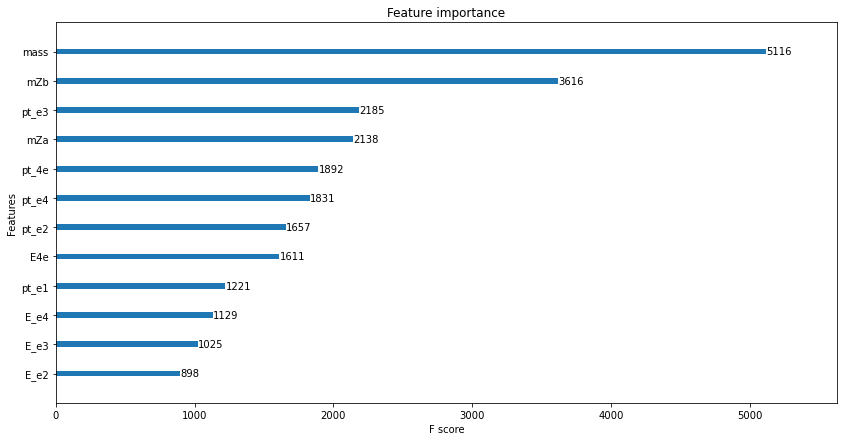

In [30]:
ax = xgb.plot_importance(classifier_4e, grid=False)
fig = ax.figure
fig.set_size_inches(14, 7)

,E4e,E_e2,E_e3,E_e4,mZa,mZb,mass,pt_4e,pt_e1,pt_e2,pt_e3,pt_e4
0,189.786103,54.809588,33.322083,21.910727,81.760708,29.722574,69.573756,-0.990745,50.121175,33.354201,20.505233,13.174789
1,189.786103,54.809588,33.322083,21.910727,81.760708,29.722574,72.878271,-0.990745,50.121175,33.354201,20.505233,13.174789
2,189.786103,54.809588,33.322083,21.910727,81.760708,29.722574,76.182787,-0.990745,50.121175,33.354201,20.505233,13.174789
3,189.786103,54.809588,33.322083,21.910727,81.760708,29.722574,79.487302,-0.990745,50.121175,33.354201,20.505233,13.174789
4,189.786103,54.809588,33.322083,21.910727,81.760708,29.722574,82.791817,-0.990745,50.121175,33.354201,20.505233,13.174789
...,...,...,...,...,...,...,...,...,...,...,...,...
124411,189.786103,54.809588,33.322083,21.910727,81.760708,29.722574,1480.601834,1087.868904,50.121175,33.354201,20.505233,13.174789
124412,189.786103,54.809588,33.322083,21.910727,81.760708,29.722574,1483.906349,1087.868904,50.121175,33.354201,20.505233,13.174789
124413,189.786103,54.809588,33.322083,21.910727,81.760708,29.722574,1487.210865,1087.868904,50.121175,33.354201,20.505233,13.174789
124414,189.786103,54.809588,33.322083,21.910727,81.760708,29.722574,1490.515380,1087.868904,50.121175,33.354201,20.505233,13.174789


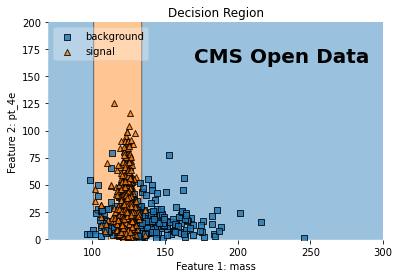

E4e = 189.7861032243979 +- 80.7655948686857
E_e2 = 54.80958774575414 +- 33.003086208487666
E_e3 = 33.32208289358938 +- 20.46806887039979
E_e4 = 21.910726588271906 +- 13.63590646161632
mZa = 81.7607077094147 +- 11.607783789678296
mZb = 29.722574353089765 +- 10.157995546055915
pt_e1 = 50.121175464784066 +- 19.36371899024193
pt_e2 = 33.354200965128555 +- 10.20572387034825
pt_e3 = 20.505233106508605 +- 6.887520923526633
pt_e4 = 13.174788524867049 +- 4.489864698412328


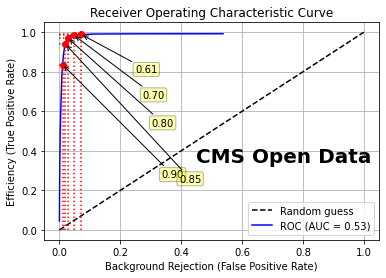

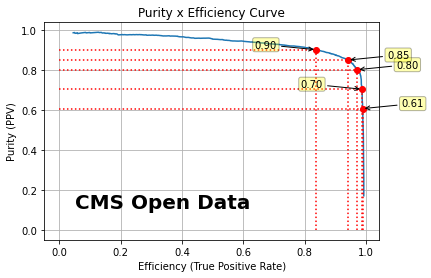

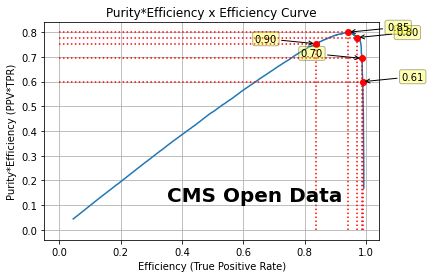

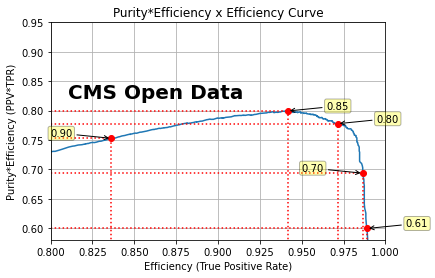

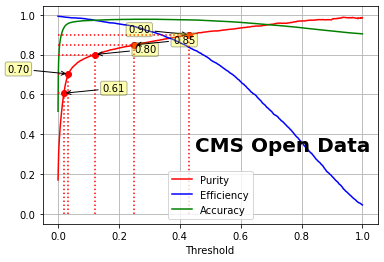

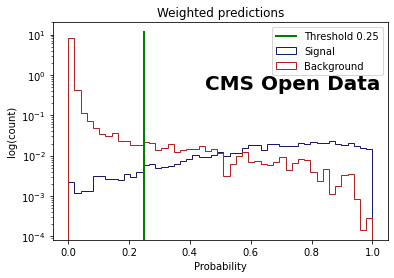

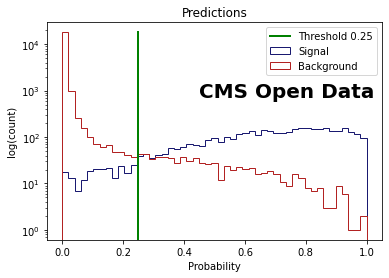

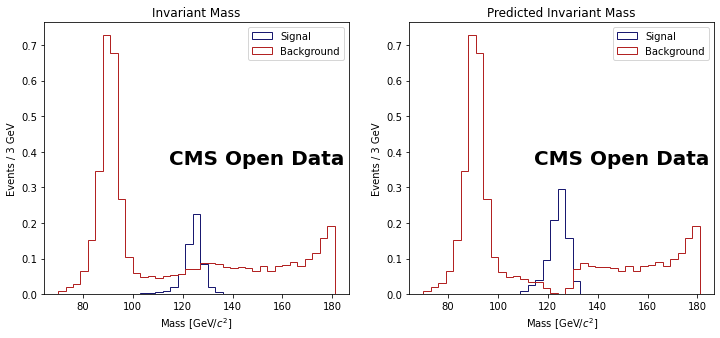

The following threshold was chosen based on maximizing ppv*tpr and it leads to the following performance indicators

Threshold: 0.2502502502502503
Purity: 0.8486441034265293
Efficiency: 0.9416841614182412
Background Rejection: 0.018708101647352284
Accuracy: 0.9773221424730554

Fraction of signal in test sample 0.10022677857526945
Fraction of signal in predicted sample 0.11121501882028383

['E4e' 'E_e2' 'E_e3' 'E_e4' 'mZa' 'mZb' 'mass' 'pt_4e' 'pt_e1' 'pt_e2'
 'pt_e3' 'pt_e4']


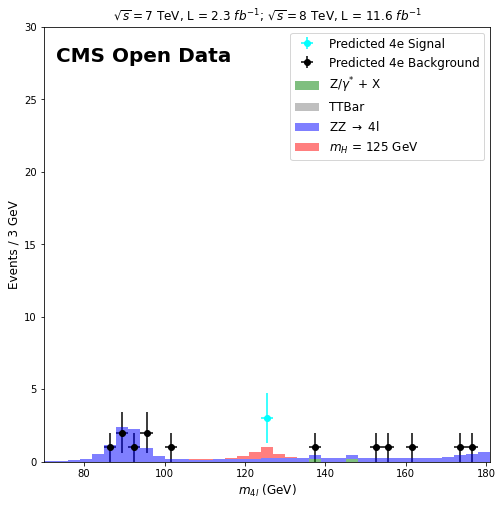

In [252]:
xgb_test_4e = xgb.DMatrix(data=X_test_4e, label=y_test_4e, weight=weights_test_4e, missing=np.nan, feature_names=features_4e)
y_pred_4e = classifier_4e.predict(xgb_test_4e)

df_pred_4e = X_test_4e.copy()
df_pred_4e["Label"] = y_test_4e
df_pred_4e["Weights"] = weights_test_4e
df_pred_4e["Prediction"] = y_pred_4e

# display(df_pred_4e)

# Performance indicators
thresholds_4e, fpr_4e, tpr_4e, ppv_4e, acc_4e = model_performance(y_test=y_test_4e, y_pred=y_pred_4e)
auc_score_4e = auc(fpr_4e, tpr_4e)

# Selecting indicators based on purity cuts from 10% to 90%
cutflow_4e = pd.DataFrame()
cutflow_4e["idx"] = [np.nanargmax(ppv_4e >= cut) for cut in [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, ppv_4e[np.nanargmax(ppv_4e*tpr_4e)]]]
cutflow_4e["purity_cut"] = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, ppv_4e[np.nanargmax(ppv_4e*tpr_4e)]]
cutflow_4e["purity"] = [ppv_4e[purity] for purity in cutflow_4e.idx]
cutflow_4e["threshold"] = [thresholds_4e[purity] for purity in cutflow_4e.idx]
cutflow_4e["efficiency"] = [tpr_4e[purity] for purity in cutflow_4e.idx]
cutflow_4e["bkg_rejection"] = [fpr_4e[purity] for purity in cutflow_4e.idx]
cutflow_4e["accuracy"] = [acc_4e[purity] for purity in cutflow_4e.idx]
cutflow_4e = cutflow_4e.drop(["idx"], axis = 1)

# Best purity cut base in max(purity*efficiency)%
bstcut_4e = pd.DataFrame()
bstcut_4e["idx"] = [np.nanargmax(ppv_4e >= ppv_4e[np.nanargmax(ppv_4e*tpr_4e)])]
bstcut_4e["purity_cut"] = [ppv_4e[np.nanargmax(ppv_4e*tpr_4e)]]
bstcut_4e["purity"] = [ppv_4e[purity] for purity in bstcut_4e.idx]
bstcut_4e["threshold"] = [thresholds_4e[purity] for purity in bstcut_4e.idx]
bstcut_4e["efficiency"] = [tpr_4e[purity] for purity in bstcut_4e.idx]
bstcut_4e["bkg_rejection"] = [fpr_4e[purity] for purity in bstcut_4e.idx]
bstcut_4e["accuracy"] = [acc_4e[purity] for purity in bstcut_4e.idx]
bstcut_4e = bstcut_4e.drop(["idx"], axis = 1)
thr_4e = bstcut_4e.threshold.values[0]

# display(cutflow_4e)
# display(bstcut_4e)

fig, ax = plt.subplots()
y = y_test_4e
X = X_test_4e.values
clf = classifier_4e
thr = thr_4e
dim = X.shape[1]
feature_names = features_4e
feature_index = (np.where(feature_names == "mass")[0][0], np.where(feature_names == "pt_4e")[0][0])
filler_feature_values = {k: X[y == 1][:,k].mean() for k in range(dim) if k not in feature_index}
filler_feature_ranges = {k: X[y == 1][:,k].std() for k in range(dim) if k not in feature_index}

plot_decision_regions(X, y, clf=clf, thr=thr,
                      feature_index=feature_index,
                      feature_names=feature_names,
                      filler_feature_values=filler_feature_values,
                      filler_feature_ranges=filler_feature_ranges,
                      legend=2, ax=ax, verbose_jupyter=True)

## -----------------------------
## CMS Notation
## -----------------------------
## Obtenção dos limites do gráfico
x_begin, x_end = plt.xlim()
y_begin, y_end = plt.ylim()

## Ajuste fino da posição
## caso o texto fique muito alto/baixo
adj_x = 100
adj_y = -920

## Inserção do texto
plt.text(x_begin + adj_x, y_end + adj_y,\
         'CMS Open Data',\
         horizontalalignment='left',\
         verticalalignment='center',\
         fontsize=20, \
         fontweight='bold')

ax.set_xlim(right=300)
ax.set_ylim(top=200)
ax.set_xlabel(f"Feature 1: {features_4e[feature_index[0]]}")
ax.set_ylabel(f"Feature 2: {features_4e[feature_index[1]]}")
ax.set_title("Decision Region")
plt.show()

for idx in filler_feature_values.keys():
    print(f"{features_4e[idx]} = {filler_feature_values[idx]} +- {filler_feature_ranges[idx]}")

plot_roc_curve(fpr = fpr_4e, tpr = tpr_4e, selection = cutflow_4e, auc = auc_score_4e)
plot_pr_curve(tpr = tpr_4e, ppv = ppv_4e, selection = cutflow_4e)
plot_prr_curve(tpr = tpr_4e, ppv = ppv_4e, selection = cutflow_4e)
plot_prr_curve_zoomed(tpr = tpr_4e, ppv = ppv_4e, selection = cutflow_4e)
plot_prat_curve(tpr = tpr_4e, ppv = ppv_4e, acc = acc_4e, thresholds = thresholds_4e, selection = cutflow_4e)

plot_predictions_with_cut(df_pred=df_pred_4e, y_pred=y_pred_4e, y_test=y_test_4e, cut=thr_4e, nbins=np.linspace(0,1,50), rang=(0, 1))
plot_predictions_with_cut(y_pred=y_pred_4e, y_test=y_test_4e, cut=thr_4e, nbins=np.linspace(0,1,50), rang=(0, 1))
# plot_mass_prediction(x_test=X_test_4e, y_pred=y_pred_4e, y_test=y_test_4e, cut=thr_4e, nbins=nbins, rang=(xmin, xmax))
plot_weighted_mass_prediction(x_test=X_test_4e, y_pred=y_pred_4e, y_test=y_test_4e, cut=thr_4e, weights=weights_test_4e, nbins=nbins, rang=(xmin, xmax))

print("The following threshold was chosen based on maximizing ppv*tpr and it leads to the following performance indicators\n")
print(f"Threshold: {thr_4e}")
print(f"Purity: {bstcut_4e.purity.values[0]}")
print(f"Efficiency: {bstcut_4e.efficiency.values[0]}")
print(f"Background Rejection: {bstcut_4e.bkg_rejection.values[0]}")
print(f"Accuracy: {bstcut_4e.accuracy.values[0]}")

print("\nFraction of signal in test sample {}".format(len(np.where(y_test_4e == 1)[0])/len(y_test_4e)))
print("Fraction of signal in predicted sample {}\n".format(len(np.where(y_pred_4e >= thr_4e)[0])/len(y_pred_4e)))

X_4e = data_4e[features_4e]
xgb_real_4e = xgb.DMatrix(data=X_4e, label=None, missing=np.nan, feature_names=features_4e)
y_4e = classifier_4e.predict(xgb_real_4e)
bkg_4e = X_4e[y_4e < thr_4e]
sig_4e = X_4e[y_4e >= thr_4e]

# Computing frequency and bins for Data, and masking the scatter plot
n_sig4e_data, bin_sig4e_edges = np.histogram(sig_4e.mass.values, bins = nbins, range = (xmin,xmax))
mask_sig4e = n_sig4e_data > 0

n_bkg4e_data, bin_bkg4e_edges = np.histogram(bkg_4e.mass.values, bins = nbins, range = (xmin,xmax))
mask_bkg4e = n_bkg4e_data > 0

# Computing frequency and bins for MC
n_HZZ_4e, bin_edges = np.histogram(mass_HZZ_4e, bins = nbins, range = (xmin,xmax), weights = weights_HZZ_4e)
n_ZZ_4e, bin_edges = np.histogram(mass_ZZ_4e, bins = nbins, range = (xmin,xmax), weights = weights_ZZ_4e)
n_TTBar_4e, bin_edges = np.histogram(mass_TTBar_4e, bins = nbins, range = (xmin,xmax), weights = weights_TTBar_4e)
n_DY50_4e, bin_edges = np.histogram(mass_DY50_4e, bins = nbins, range = (xmin,xmax), weights = weights_DY50_4e)

# Computing bin width and x-axis centered values
width = 1.0*(bin_edges[1] - bin_edges[0])
center = (bin_edges[:-1] + bin_edges[1:])/2.

print(features_4e)

# Ploting using bar method
plt.figure(figsize = (8,8))
plt.errorbar(center[mask_sig4e], n_sig4e_data[mask_sig4e], yerr = np.sqrt(n_sig4e_data[mask_sig4e]), xerr = (width/2)*np.ones(n_sig4e_data[mask_sig4e].size), marker = "o", color = "cyan", linestyle = 'None', label = "Predicted 4e Signal", zorder=1)
plt.errorbar(center[mask_bkg4e], n_bkg4e_data[mask_bkg4e], yerr = np.sqrt(n_bkg4e_data[mask_bkg4e]), xerr = (width/2)*np.ones(n_bkg4e_data[mask_bkg4e].size), marker = "o", color = "black", linestyle = 'None', label = "Predicted 4e Background", zorder=1)
plt.bar(center, n_DY50_4e, width = width, align = 'center', color = "g", bottom = n_TTBar_4e, linewidth = 0, edgecolor = 'black', alpha = 0.5, label = 'Z/$\gamma^{*}$ + X')
plt.bar(center, n_TTBar_4e, width = width, align = 'center', color = "grey", linewidth = 0, edgecolor = 'black', alpha = 0.5, label = r'TTBar')
plt.bar(center, n_ZZ_4e, width = width, align = 'center', color = "b", bottom = n_TTBar_4e+n_DY50_4e, linewidth = 0, edgecolor = 'black', alpha = 0.5, label = r'ZZ $\rightarrow$ 4l')
plt.bar(center, n_HZZ_4e, width = width, align = 'center', color = 'r', bottom = n_TTBar_4e+n_DY50_4e+n_ZZ_4e, linewidth = 0, edgecolor = 'black', alpha = 0.5, label = '$m_{H}$ = 125 GeV')
plt.xlim((xmin,xmax))
plt.ylim((0, 30))

## -----------------------------
## CMS Notation
## -----------------------------
## Obtenção dos limites do gráfico
x_begin, x_end = plt.xlim()
y_begin, y_end = plt.ylim()

## Ajuste fino da posição
## caso o texto fique muito alto/baixo
adj_x = 3
adj_y = -2

## Inserção do texto
plt.text(x_begin + adj_x, y_end + adj_y,\
         'CMS Open Data',\
         horizontalalignment='left',\
         verticalalignment='center',\
         fontsize=20, \
         fontweight='bold')

plt.xlabel('$m_{4l}$ (GeV)', fontsize = 12)
plt.ylabel(f'Events / {int(width)} GeV', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize = 12)
# plt.savefig("mass-predicted--4e.png", dpi = 300)
plt.show()

# Training XGBOOST for 2mu2e events

In [32]:
lbl = preprocessing.LabelEncoder()
mc_2mu2e["Label"] = lbl.fit_transform(mc_2mu2e.Label.astype(str))
train_2mu2e, test_2mu2e = train_test_split(mc_2mu2e, test_size=test_size, random_state=random_state)
train_2mu2e, test_2mu2e = train_2mu2e.reset_index(drop=True), test_2mu2e.reset_index(drop=True)

n_signal_2mu2e = len(np.where(mc_2mu2e.Label == 1)[0])
n_background_2mu2e = len(np.where(mc_2mu2e.Label == 0)[0])
n_events_2mu2e = n_signal_2mu2e + n_background_2mu2e

print(f"Number of signal events: {n_signal_2mu2e}")
print(f"Number of background events: {n_background_2mu2e}")
print(f"Fraction of signal: {n_signal_2mu2e/n_events_2mu2e}")

variables_2mu2e = mc_2mu2e.columns.values
remove = np.array([
    "cas_2mu2", "cas_2e2", "cas_2mu1", "cas_2e1", "pz_2e1", "pz_2e2", "pz_2mu2", "pz_2mu1", 
    "pz2mu2e", "px_2e1", "px_2mu1", "py_2e2", "phi_2e2", "py_2mu2", "py_2e1", "phi_2mu2", 
    "py2mu2e", "phi_2e1", "px2mu2e", "px_2e2", "phi_2mu1", "eta_2mu2e", "px_2mu2",
    "eta_2e2", "eta_2mu2", "eta_2mu1", "eta_2e1"
])
features_2mu2e = np.delete(variables_2mu2e, np.where(variables_2mu2e == "Event"), axis=0)
features_2mu2e = np.delete(features_2mu2e, np.where(features_2mu2e == "Label"), axis=0)
features_2mu2e = np.delete(features_2mu2e, np.where(features_2mu2e == "Weights"), axis=0)
features_2mu2e = np.setdiff1d(features_2mu2e, remove)

X_train_2mu2e, y_train_2mu2e = train_2mu2e, train_2mu2e.Label.values
X_test_2mu2e, y_test_2mu2e = test_2mu2e[features_2mu2e], test_2mu2e.Label.values

weights_train_2mu2e, evt_train_2mu2e = train_2mu2e.Weights.values, train_2mu2e.Event.values
weights_test_2mu2e, evt_test_2mu2e = test_2mu2e.Weights.values, test_2mu2e.Event.values

condition_zz_hzz = np.where(~((X_train_2mu2e.Event.values != "ZZ4mu-12") &
                    (X_train_2mu2e.Event.values != "ZZ4e-12") &
                    (X_train_2mu2e.Event.values != "ZZ2mu2e-12") &
                    (X_train_2mu2e.Event.values != "ZZ4mu-11") &
                    (X_train_2mu2e.Event.values != "ZZ4e-11") &
                    (X_train_2mu2e.Event.values != "ZZ2mu2e-11") &
                    (X_train_2mu2e.Event.values != "HZZ4mu-12") &
                    (X_train_2mu2e.Event.values != "HZZ4e-12") &
                    (X_train_2mu2e.Event.values != "HZZ2mu2e-12") &
                    (X_train_2mu2e.Event.values != "HZZ4mu-11") &
                    (X_train_2mu2e.Event.values != "HZZ4e-11") &
                    (X_train_2mu2e.Event.values != "HZZ2mu2e-11")))

weights_train_2mu2e = weights_train_2mu2e[condition_zz_hzz[0]]
y_train_2mu2e = y_train_2mu2e[condition_zz_hzz[0]]
X_train_2mu2e = X_train_2mu2e.iloc[condition_zz_hzz[0]].reset_index(drop=True)
X_train_2mu2e = X_train_2mu2e[features_2mu2e]

Number of signal events: 32873
Number of background events: 127617
Fraction of signal: 0.20482896130600037


In [33]:
params = {
        'min_child_weight': [1, 10, 50, 100, 200],
        'eta': [0.001, 0.01, 0.05, 0.1],
        'subsample': [0.5, 0.6, 0.8],
        'colsample_bytree': [0.5, 0.6, 0.8],
        'max_depth': [3, 4, 5, 6, 7, 8, 9]
        }

xgb_clas = XGBClassifier(learning_rate=0.02, n_estimators=3000, objective='binary:logistic', nthread=8)
skf_2mu2e = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
random_search_2mu2e = RandomizedSearchCV(xgb_clas, param_distributions=params, n_iter=param_comb, 
                                         scoring='f1', n_jobs=-1, cv=skf_2mu2e.split(X_train_2mu2e,y_train_2mu2e), 
                                         verbose=3, random_state=random_state)

random_search_2mu2e.fit(X_train_2mu2e, y_train_2mu2e, sample_weight=weights_train_2mu2e)
hyperparams_2mu2e = random_search_2mu2e.best_params_
bst_classifier_2mu2e = random_search_2mu2e.best_estimator_

print(hyperparams_2mu2e)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  9.6min remaining: 14.4min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 17.5min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 17.5min finished


{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 8, 'eta': 0.05, 'colsample_bytree': 0.8}


In [34]:
xgb_train_2mu2e = xgb.DMatrix(data=X_train_2mu2e, label=y_train_2mu2e, weight=weights_train_2mu2e, missing=np.nan, feature_names=features_2mu2e)
classifier_2mu2e = xgb.train(params=hyperparams_2mu2e, dtrain=xgb_train_2mu2e, num_boost_round=3000)

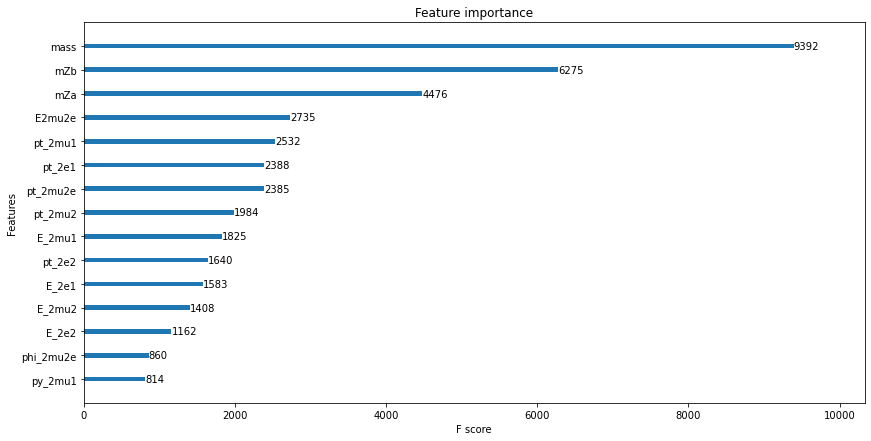

In [35]:
ax = xgb.plot_importance(classifier_2mu2e, grid=False)
fig = ax.figure
fig.set_size_inches(14, 7)

,E2mu2e,E_2e1,E_2e2,E_2mu1,E_2mu2,mZa,mZb,mass,phi_2mu2e,pt_2e1,pt_2e2,pt_2mu1,pt_2mu2,pt_2mu2e,py_2mu1
0,193.473858,62.048308,39.634317,56.153017,35.638216,83.227877,28.442787,69.050384,-4.141581,38.092246,23.469812,34.635985,20.444794,40.878659,0.137658
1,193.473858,62.048308,39.634317,56.153017,35.638216,83.227877,28.442787,73.336427,-4.141581,38.092246,23.469812,34.635985,20.444794,40.878659,0.137658
2,193.473858,62.048308,39.634317,56.153017,35.638216,83.227877,28.442787,77.622470,-4.141581,38.092246,23.469812,34.635985,20.444794,40.878659,0.137658
3,193.473858,62.048308,39.634317,56.153017,35.638216,83.227877,28.442787,81.908513,-4.141581,38.092246,23.469812,34.635985,20.444794,40.878659,0.137658
4,193.473858,62.048308,39.634317,56.153017,35.638216,83.227877,28.442787,86.194556,-4.141581,38.092246,23.469812,34.635985,20.444794,40.878659,0.137658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124411,193.473858,62.048308,39.634317,56.153017,35.638216,83.227877,28.442787,1899.190686,4.141592,38.092246,23.469812,34.635985,20.444794,40.878659,0.137658
124412,193.473858,62.048308,39.634317,56.153017,35.638216,83.227877,28.442787,1903.476729,4.141592,38.092246,23.469812,34.635985,20.444794,40.878659,0.137658
124413,193.473858,62.048308,39.634317,56.153017,35.638216,83.227877,28.442787,1907.762772,4.141592,38.092246,23.469812,34.635985,20.444794,40.878659,0.137658
124414,193.473858,62.048308,39.634317,56.153017,35.638216,83.227877,28.442787,1912.048815,4.141592,38.092246,23.469812,34.635985,20.444794,40.878659,0.137658


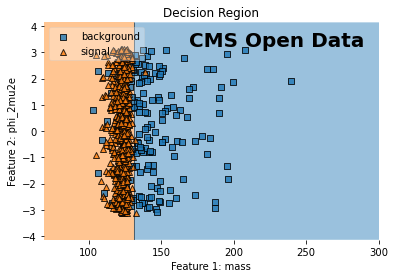

E2mu2e = 193.47385763168467 +- 85.41954182451741
E_2e1 = 62.0483077622997 +- 48.58666107137336
E_2e2 = 39.63431712167013 +- 30.037109341909044
E_2mu1 = 56.153017213109884 +- 45.057806058033165
E_2mu2 = 35.63821553815676 +- 29.811848468015068
mZa = 83.22787680825759 +- 12.025462512839162
mZb = 28.442786995770273 +- 9.508088779294658
pt_2e1 = 38.09224619939727 +- 21.27113016616083
pt_2e2 = 23.469811554211784 +- 12.329131413908426
pt_2mu1 = 34.6359853645588 +- 21.423032705110234
pt_2mu2 = 20.44479398914639 +- 12.48562494402442
pt_2mu2e = 40.87865885834195 +- 45.004659994452304
py_2mu1 = 0.1376576826341383 +- 28.72915391836681


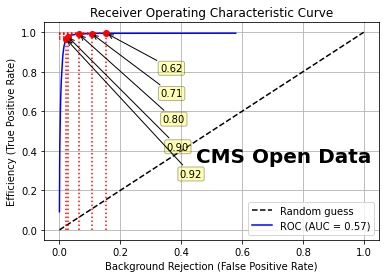

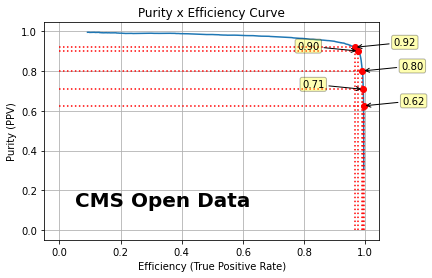

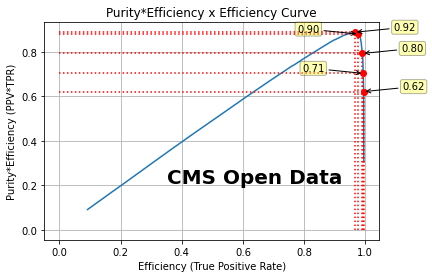

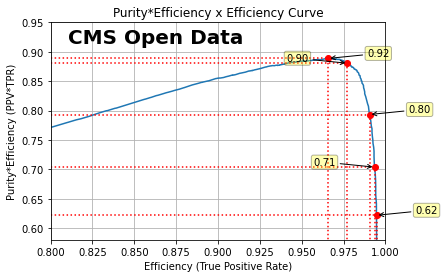

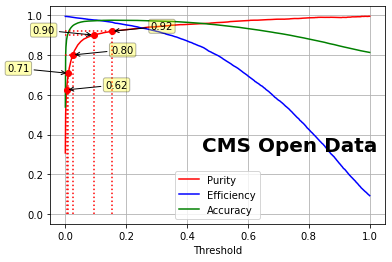

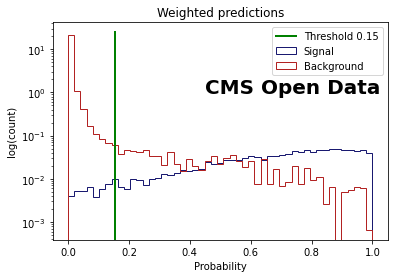

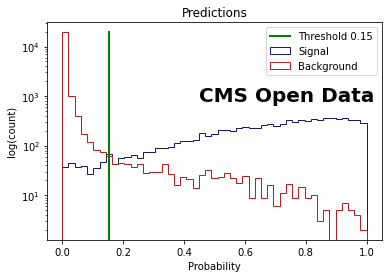

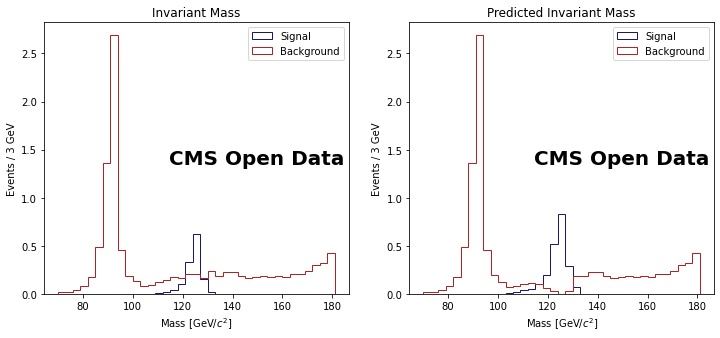

The following threshold was chosen based on maximizing ppv*tpr and it leads to the following performance indicators

Threshold: 0.15315315315315314
Purity: 0.92
Efficiency: 0.9658975915806517
Background Rejection: 0.021690840193388215
Accuracy: 0.9757617297027852

Fraction of signal in test sample 0.20524643279955138
Fraction of signal in predicted sample 0.2154859077408769

['E2mu2e' 'E_2e1' 'E_2e2' 'E_2mu1' 'E_2mu2' 'mZa' 'mZb' 'mass' 'phi_2mu2e'
 'pt_2e1' 'pt_2e2' 'pt_2mu1' 'pt_2mu2' 'pt_2mu2e' 'py_2mu1']


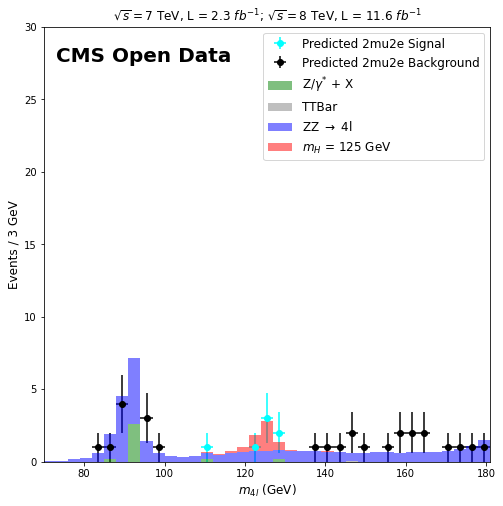

In [253]:
xgb_test_2mu2e = xgb.DMatrix(data=X_test_2mu2e, label=y_test_2mu2e, weight=weights_test_2mu2e, missing=np.nan, feature_names=features_2mu2e)
y_pred_2mu2e = classifier_2mu2e.predict(xgb_test_2mu2e)

df_pred_2mu2e = X_test_2mu2e.copy()
df_pred_2mu2e["Label"] = y_test_2mu2e
df_pred_2mu2e["Weights"] = weights_test_2mu2e
df_pred_2mu2e["Prediction"] = y_pred_2mu2e

# display(df_pred_2mu2e)

# Performance indicators
thresholds_2mu2e, fpr_2mu2e, tpr_2mu2e, ppv_2mu2e, acc_2mu2e = model_performance(y_test=y_test_2mu2e, y_pred=y_pred_2mu2e)
auc_score_2mu2e = auc(fpr_2mu2e, tpr_2mu2e)

# Selecting indicators based on purity cuts from 10% to 90%
cutflow_2mu2e = pd.DataFrame()
cutflow_2mu2e["idx"] = [np.nanargmax(ppv_2mu2e >= cut) for cut in [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, ppv_2mu2e[np.nanargmax(ppv_2mu2e*tpr_2mu2e)]]]
cutflow_2mu2e["purity_cut"] = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, ppv_2mu2e[np.nanargmax(ppv_2mu2e*tpr_2mu2e)]]
cutflow_2mu2e["purity"] = [ppv_2mu2e[purity] for purity in cutflow_2mu2e.idx]
cutflow_2mu2e["threshold"] = [thresholds_2mu2e[purity] for purity in cutflow_2mu2e.idx]
cutflow_2mu2e["efficiency"] = [tpr_2mu2e[purity] for purity in cutflow_2mu2e.idx]
cutflow_2mu2e["bkg_rejection"] = [fpr_2mu2e[purity] for purity in cutflow_2mu2e.idx]
cutflow_2mu2e["accuracy"] = [acc_2mu2e[purity] for purity in cutflow_2mu2e.idx]
cutflow_2mu2e = cutflow_2mu2e.drop(["idx"], axis = 1)

# Best purity cut base in max(purity*efficiency)%
bstcut_2mu2e = pd.DataFrame()
bstcut_2mu2e["idx"] = [np.nanargmax(ppv_2mu2e >= ppv_2mu2e[np.nanargmax(ppv_2mu2e*tpr_2mu2e)])]
bstcut_2mu2e["purity_cut"] = [ppv_2mu2e[np.nanargmax(ppv_2mu2e*tpr_2mu2e)]]
bstcut_2mu2e["purity"] = [ppv_2mu2e[purity] for purity in bstcut_2mu2e.idx]
bstcut_2mu2e["threshold"] = [thresholds_2mu2e[purity] for purity in bstcut_2mu2e.idx]
bstcut_2mu2e["efficiency"] = [tpr_2mu2e[purity] for purity in bstcut_2mu2e.idx]
bstcut_2mu2e["bkg_rejection"] = [fpr_2mu2e[purity] for purity in bstcut_2mu2e.idx]
bstcut_2mu2e["accuracy"] = [acc_2mu2e[purity] for purity in bstcut_2mu2e.idx]
bstcut_2mu2e = bstcut_2mu2e.drop(["idx"], axis = 1)
thr_2mu2e = bstcut_2mu2e.threshold.values[0]

# display(cutflow_2mu2e)
# display(bstcut_2mu2e)

fig, ax = plt.subplots()
y = y_test_2mu2e
X = X_test_2mu2e.values
clf = classifier_2mu2e
thr = thr_2mu2e
dim = X.shape[1]
feature_names = features_2mu2e
feature_index = (np.where(feature_names == "mass")[0][0], np.where(feature_names == "phi_2mu2e")[0][0])
filler_feature_values = {k: X[y == 1][:,k].mean() for k in range(dim) if k not in feature_index}
filler_feature_ranges = {k: X[y == 1][:,k].std() for k in range(dim) if k not in feature_index}

plot_decision_regions(X, y, clf=clf, thr=thr,
                      feature_index=feature_index,
                      feature_names=feature_names,
                      filler_feature_values=filler_feature_values,
                      filler_feature_ranges=filler_feature_ranges,
                      legend=2, ax=ax, verbose_jupyter=True)

## -----------------------------
## CMS Notation
## -----------------------------
## Obtenção dos limites do gráfico
x_begin, x_end = plt.xlim()
y_begin, y_end = plt.ylim()

## Ajuste fino da posição
## caso o texto fique muito alto/baixo
adj_x = 100
adj_y = -0.7

## Inserção do texto
plt.text(x_begin + adj_x, y_end + adj_y,\
         'CMS Open Data',\
         horizontalalignment='left',\
         verticalalignment='center',\
         fontsize=20, \
         fontweight='bold')

ax.set_xlim(right=300)
ax.set_xlabel(f"Feature 1: {features_2mu2e[feature_index[0]]}")
ax.set_ylabel(f"Feature 2: {features_2mu2e[feature_index[1]]}")
ax.set_title("Decision Region")
plt.show()


for idx in filler_feature_values.keys():
    print(f"{features_2mu2e[idx]} = {filler_feature_values[idx]} +- {filler_feature_ranges[idx]}")

plot_roc_curve(fpr = fpr_2mu2e, tpr = tpr_2mu2e, selection = cutflow_2mu2e, auc = auc_score_2mu2e)
plot_pr_curve(tpr = tpr_2mu2e, ppv = ppv_2mu2e, selection = cutflow_2mu2e)
plot_prr_curve(tpr = tpr_2mu2e, ppv = ppv_2mu2e, selection = cutflow_2mu2e)
plot_prr_curve_zoomed(tpr = tpr_2mu2e, ppv = ppv_2mu2e, selection = cutflow_2mu2e)
plot_prat_curve(tpr = tpr_2mu2e, ppv = ppv_2mu2e, acc = acc_2mu2e, thresholds = thresholds_2mu2e, selection = cutflow_2mu2e)

plot_predictions_with_cut(df_pred=df_pred_2mu2e, y_pred=y_pred_2mu2e, y_test=y_test_2mu2e, cut=thr_2mu2e, nbins=np.linspace(0,1,50), rang=(0, 1))
plot_predictions_with_cut(y_pred=y_pred_2mu2e, y_test=y_test_2mu2e, cut=thr_2mu2e, nbins=np.linspace(0,1,50), rang=(0, 1))
#plot_mass_prediction(x_test=X_test_2mu2e, y_pred=y_pred_2mu2e, y_test=y_test_2mu2e, cut=thr_2mu2e, nbins=nbins, rang=(xmin, xmax))
plot_weighted_mass_prediction(x_test=X_test_2mu2e, y_pred=y_pred_2mu2e, y_test=y_test_2mu2e, cut=thr_2mu2e, weights=weights_test_2mu2e, nbins=nbins, rang=(xmin, xmax))

print("The following threshold was chosen based on maximizing ppv*tpr and it leads to the following performance indicators\n")
print(f"Threshold: {thr_2mu2e}")
print(f"Purity: {bstcut_2mu2e.purity.values[0]}")
print(f"Efficiency: {bstcut_2mu2e.efficiency.values[0]}")
print(f"Background Rejection: {bstcut_2mu2e.bkg_rejection.values[0]}")
print(f"Accuracy: {bstcut_2mu2e.accuracy.values[0]}")

print("\nFraction of signal in test sample {}".format(len(np.where(y_test_2mu2e == 1)[0])/len(y_test_2mu2e)))
print("Fraction of signal in predicted sample {}\n".format(len(np.where(y_pred_2mu2e >= thr_2mu2e)[0])/len(y_pred_2mu2e)))

X_2mu2e = data_2mu2e[features_2mu2e]
xgb_real_2mu2e = xgb.DMatrix(data=X_2mu2e, label=None, missing=np.nan, feature_names=features_2mu2e)
y_2mu2e = classifier_2mu2e.predict(xgb_real_2mu2e)
bkg_2mu2e = X_2mu2e[y_2mu2e < thr_2mu2e]
sig_2mu2e = X_2mu2e[y_2mu2e >= thr_2mu2e]

# Computing frequency and bins for Data, and masking the scatter plot
n_sig2mu2e_data, bin_sig2mu2e_edges = np.histogram(sig_2mu2e.mass.values, bins = nbins, range=(xmin,xmax))
mask_sig2mu2e = n_sig2mu2e_data > 0

n_bkg2mu2e_data, bin_bkg2mu2e_edges = np.histogram(bkg_2mu2e.mass.values, bins = nbins, range=(xmin,xmax))
mask_bkg2mu2e = n_bkg2mu2e_data > 0

# Computing frequency and bins for MC
n_HZZ_2mu2e, bin_edges = np.histogram(mass_HZZ_2mu2e, bins=nbins, range=(xmin,xmax), weights=weights_HZZ_2mu2e)
n_ZZ_2mu2e, bin_edges = np.histogram(mass_ZZ_2mu2e, bins=nbins, range=(xmin,xmax), weights=weights_ZZ_2mu2e)
n_TTBar_2mu2e, bin_edges = np.histogram(mass_TTBar_2mu2e, bins=nbins, range=(xmin,xmax), weights=weights_TTBar_2mu2e)
n_DY50_2mu2e, bin_edges = np.histogram(mass_DY50_2mu2e, bins=nbins, range=(xmin,xmax), weights=weights_DY50_2mu2e)

# Computing bin width and x-axis centered values
width = 1.0*(bin_edges[1] - bin_edges[0])
center = (bin_edges[:-1] + bin_edges[1:])/2.

print(features_2mu2e)

# Ploting using bar method
plt.figure(figsize = (8,8))
plt.errorbar(center[mask_sig2mu2e], n_sig2mu2e_data[mask_sig2mu2e], yerr=np.sqrt(n_sig2mu2e_data[mask_sig2mu2e]), xerr=(width/2)*np.ones(n_sig2mu2e_data[mask_sig2mu2e].size), marker="o", color="cyan", linestyle='None', label="Predicted 2mu2e Signal", zorder=1)
plt.errorbar(center[mask_bkg2mu2e], n_bkg2mu2e_data[mask_bkg2mu2e], yerr=np.sqrt(n_bkg2mu2e_data[mask_bkg2mu2e]), xerr=(width/2)*np.ones(n_bkg2mu2e_data[mask_bkg2mu2e].size), marker="o", color="black", linestyle='None', label="Predicted 2mu2e Background", zorder=1)
plt.bar(center, n_DY50_2mu2e, width=width, align='center', color="g", bottom=n_TTBar_2mu2e, linewidth=0, edgecolor='black', alpha=0.5, label='Z/$\gamma^{*}$ + X')
plt.bar(center, n_TTBar_2mu2e, width=width, align='center', color="grey", linewidth=0, edgecolor='black', alpha=0.5, label=r'TTBar')
plt.bar(center, n_ZZ_2mu2e, width=width, align='center', color="b", bottom=n_TTBar_2mu2e+n_DY50_2mu2e, linewidth=0, edgecolor='black', alpha=0.5, label=r'ZZ $\rightarrow$ 4l')
plt.bar(center, n_HZZ_2mu2e, width=width, align='center', color='r', bottom=n_TTBar_2mu2e+n_DY50_2mu2e+n_ZZ_2mu2e, linewidth=0, edgecolor='black', alpha=0.5, label='$m_{H}$ = 125 GeV')
plt.xlim((xmin,xmax))
plt.ylim((0, 30))

## -----------------------------
## CMS Notation
## -----------------------------
## Obtenção dos limites do gráfico
x_begin, x_end = plt.xlim()
y_begin, y_end = plt.ylim()

## Ajuste fino da posição
## caso o texto fique muito alto/baixo
adj_x = 3
adj_y = -2

## Inserção do texto
plt.text(x_begin + adj_x, y_end + adj_y,\
         'CMS Open Data',\
         horizontalalignment='left',\
         verticalalignment='center',\
         fontsize=20, \
         fontweight='bold')

plt.xlabel('$m_{4l}$ (GeV)', fontsize=12)
plt.ylabel(f'Events / {int(width)} GeV', fontsize=12)
plt.legend(fontsize=12)
plt.title('$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize=12)
# plt.savefig("mass-predicted-2mu2e.png", dpi = 300)
plt.show()


# Visualizing all predictions together

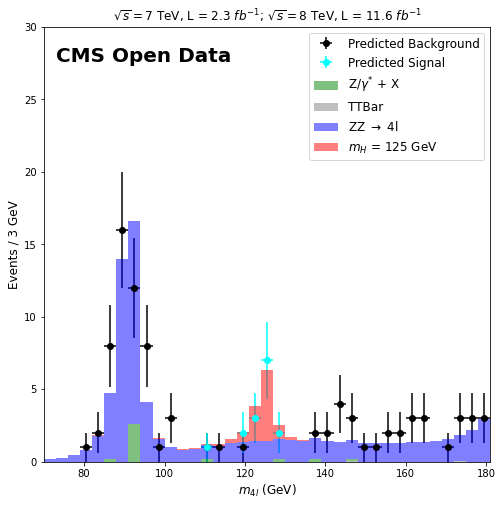

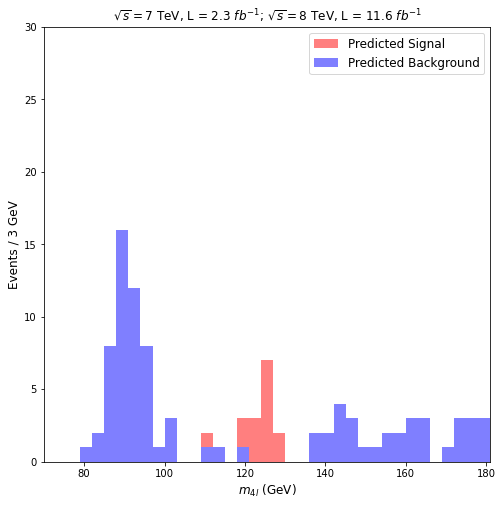

In [234]:
mass_bkg_4mu = bkg_4mu.mass.values
mass_bkg_4e = bkg_4e.mass.values
mass_bkg_2mu2e = bkg_2mu2e.mass.values
mass_background = np.concatenate([mass_bkg_4mu, mass_bkg_4e, mass_bkg_2mu2e], axis=0)

mass_sig_4mu = sig_4mu.mass.values
mass_sig_4e = sig_4e.mass.values
mass_sig_2mu2e = sig_2mu2e.mass.values
mass_signal = np.concatenate([mass_sig_4mu, mass_sig_4e, mass_sig_2mu2e], axis=0)

# Computing frequency and bins for Data, and masking the scatter plot
n_signal, bin_signal_edges = np.histogram(mass_signal, bins=nbins, range=(xmin,xmax))
mask_signal = n_signal > 0

n_background, bin_background_edges = np.histogram(mass_background, bins=nbins, range=(xmin,xmax))
mask_background = n_background > 0

# Computing frequency and bins for MC
n_HZZ, bin_edges = np.histogram(massHZZ, bins=nbins, range=(xmin,xmax), weights=weightsHZZ)
n_ZZ, bin_edges = np.histogram(massZZ, bins=nbins, range=(xmin,xmax), weights=weightsZZ)
n_TTBar, bin_edges = np.histogram(massTTBar, bins=nbins, range=(xmin,xmax), weights=weightsTTBar)
n_DY, bin_edges = np.histogram(massDY, bins=nbins, range=(xmin,xmax), weights=weightsDY)

HZZ_mask = n_HZZ > 0
ZZ_mask = n_ZZ > 0
TTBar_mask = n_TTBar > 0
DY_mask = n_DY > 0

# Computing bin width and x-axis centered values
width = 1.0*(bin_edges[1] - bin_edges[0])
center = (bin_edges[:-1] + bin_edges[1:])/2.

# Ploting using bar method
plt.figure(figsize = (8,8))
plt.errorbar(center[mask_background], n_background[mask_background], yerr=np.sqrt(n_background[mask_background]), xerr=(width/2)*np.ones(n_background[mask_background].size), marker="o", color="black", linestyle='None', label="Predicted Background", zorder=1)
plt.errorbar(center[mask_signal], n_signal[mask_signal], yerr=np.sqrt(n_signal[mask_signal]), xerr=(width/2)*np.ones(n_signal[mask_signal].size), marker="o", color="cyan", linestyle='None', label="Predicted Signal", zorder=1)
plt.bar(center, n_DY, width=width, align='center', color="g", bottom=n_TTbar, linewidth=0, edgecolor='black', alpha=0.5, label='Z/$\gamma^{*}$ + X')
plt.bar(center, n_TTBar, width=width, align='center', color="grey", linewidth=0, edgecolor='black', alpha=0.5, label=r'TTBar')
plt.bar(center, n_ZZ, width=width, align='center', color="b", bottom=n_TTbar+n_DY, linewidth=0, edgecolor='black', alpha=0.5, label=r'ZZ $\rightarrow$ 4l')
plt.bar(center, n_HZZ, width=width, align='center', color='r', bottom=n_TTbar+n_DY+n_ZZ, linewidth=0, edgecolor='black', alpha=0.5, label='$m_{H}$ = 125 GeV')
plt.xlim((xmin,xmax))
plt.ylim((0, 30))

## -----------------------------
## CMS Notation
## -----------------------------
## Obtenção dos limites do gráfico
x_begin, x_end = plt.xlim()
y_begin, y_end = plt.ylim()

## Ajuste fino da posição
## caso o texto fique muito alto/baixo
adj_x = 3
adj_y = -2

## Inserção do texto
plt.text(x_begin + adj_x, y_end + adj_y,\
         'CMS Open Data',\
         horizontalalignment='left',\
         verticalalignment='center',\
         fontsize=20, \
         fontweight='bold')

plt.xlabel('$m_{4l}$ (GeV)', fontsize=12)
plt.ylabel(f'Events / {int(width)} GeV', fontsize=12)
plt.legend(fontsize=12)
plt.title('$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize=12)
# plt.savefig("mass4l_combined_predicted.png", dpi = 300)
plt.show()

# Ploting using bar method
plt.figure(figsize = (8,8))
plt.bar(center, n_signal, width=width, align='center', color="r", bottom=n_background, linewidth=0, edgecolor='black', alpha=0.5, label="Predicted Signal")
plt.bar(center, n_background, width=width, align='center', color="b", linewidth=0, edgecolor='black', alpha=0.5, label="Predicted Background")
plt.xlim((xmin,xmax))
plt.ylim((0, 30))
plt.xlabel('$m_{4l}$ (GeV)', fontsize=12)
plt.ylabel(f'Events / {int(width)} GeV', fontsize=12)
plt.legend(fontsize=12)
plt.title('$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize=12)
plt.show()